# **Multi-Strategy Backtester and Forensic Data Visualizer**
This script calls a long list of functions on raw price data from the stock chipper project. The many functions here perform indicator calculations, calculate strategy signals that use said indicators, visualization feature relationships, and create performance summaries, among other things. In order to work new strategies into the performance summaries, create a signal creating function that contains the programming expressions of the strategies' logics. For a new strategy to flow seemless to the performance summaries, the signal creating function must create signal containing columns whose names begin with the substring 'signal_', and the values of these signal columns must be comprised of only 1 (market long), 0 (market neutral), and -1 (market short). A new signal function and its invokation must also be positioned with the other signal creating functions and their invokations, respectively. Prerequisite indicators may need to be worked in at appropriate points in the script if they are not already here.

## **Table of Contents**
- [Data Retrieval, Hopper Filtering, and Coefficient of Variance of Price Analysis](#Data-Retrieval,-Hopper-Filtering,-and-Coefficient-of-Variance-of-Price-Analysis)
  - [All Tickers Raw: Tickers from GBQ, CV(price&volume), Filtering](#All-Tickers-Raw:-Tickers-from-GBQ,-CV(price&volume),-Filtering)
  - [Ticker Price/Volume CV Visual Playground](#Ticker-Price/Volume-CV-Visual-Playground)
  - [OHLC Data Retrieval](#OHLC-Data-Retrieval)
  - [Visualizing CV(price) Over Time](#Visualizing-CV(price)-Over-Time)
  - [Cash Vertical, Signal Match Shift, OHLC Average](#Cash-Vertical,-Signal-Match-Shift,-OHLC-Average)
  - []()
- [Indicator Calculations](#indicator-calculations)
  - [Simple Moving Averages](#Simple-Moving-Averages)
  - [Weighted Moving Averages](#Weighted-Moving-Averages)
  - [Moving Average Ribbon Sum of Differences](#Moving-Average-Ribbon-Sum-of-Differences-(MARSOD))
  - [Weighted Moving Average Ribbon Sum of Differences](#Weighted-Moving-Average-Ribbon-Sum-of-Differences-(W-MARSOD))
  - [Squeeze and Regression-Based Momentum Histogram](#Squeeze-and-Regression-Based-Momentum-Histogram)
  - [Relative Strength Indices](#Relative-Strength-Indices)
  - [Keltner Channels and Bollinger Bands (TTM Squeeze Components)](#Keltner-Channels-and-Bollinger-Bands-(TTM-Squeeze-Components))
  - [Volume Weighted Average Price, Pivot Point, and S/Rs](#Volume-Weighted-Average-Price,-Pivot-Point,-and-S/Rs)
  - [All Numerical First and Second Derivatives](#All-Numerical-First-and-Second-Derivatives)
  - []()
- [Functions for Signal Generation and Profit/Loss Calculation](#functions-for-signal-generation-and-profit/loss-calculation)
  - [Signal and P/L Function Definitions](#Signal-and-P/L-Function-Definitions)
  - [Calling Signal and P/L Functions](#Calling-Signal-and-P/L-Functions)
  - [QA for New Features](#QA-for-New-Features)
  - [Write Data to CSV and/or GBQ](#Write-Data-to-CSV-and/or-GBQ)
  - []()
- [Visualizing Monthly CV Against Monthly Profit by Scatterplot](#visualizing-monthly-cv-against-monthly-profit-by-scatterplot)
  - [Scatterplot Function Variations for Dataframe Dictionaries](#Scatterplot-Function-Variations-for-Dataframe-Dictionaries)
  - [Ticker-Month CV(price) vs Mean Price Scatterplot](#Ticker-Month-CV(price)-vs-Mean-Price-Scatterplot)
  - []()
- [Performance Summaries](#performance-summaries)
  - [Permormance Summary Function](#Permormance-Summary-Function)
  - [Calling Performance Summary Function](#Calling-Performance-Summary-Function)
  - []()
- [The Performance Summary Data for All Strategies and All Tickers](#the-performance-summary-data-for-all-strategies-and-all-tickers)
  - [Performance Tables](#Performance-Tables)
  - [CV(price) to Profit Scatterplot](#CV(price)-to-Profit-Scatterplot)
  - [Run-time, Stopper, Display Reset](#Run-time,-Stopper,-Display-Reset)
  - []()
- [Profit Curve and Trade Visualizations](#Profit-Curve-and-Trade-Visualizations)
  - [Cumulative Profit Curves](#Cumulative-Profit-Curves)
  - [Trade Visualization](#Trade-Visualization)
  - [Newest Trade Plot](#Newest-Trade-Plot)
  - []()

### **Todo List**
**Main Objective: Build the roster of tickers, find out what characteristics predict ticker success for wma_derivative_2 strategies.**

**Progression, Analysis:**
- visualize trades of any ticker, any strategy (done) make indicator viz dynamic ***
- scatterplot CVprice and verticality ***
- modify SQL to avoid incomplete ticker data (done)
- fix vwap and pivot points (done)
- randomize dates
- calculate more indicators
- write more algorithmic strats
- look for missing price data and impute candles
- replace nan and inf with values that make sense for each column
-

**Engineering, Functional:**
- translate functions to OOP and create .py file ***
- save data to GBQ after settling on filters and timeframe ***
- incorporate parallel processing ***
- Charles Schwab API/trading applications **
- Copilot ***

**Cosmetic, Ease-of-Use:**
- create links to key areas in the script ***
- Complete documentation: hashtag, triple quote, and summaries ***
-

In [1]:
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_ta as ta
from scipy import stats
import re
from Multi_Strat_Back_Tester_Functions import *


# Yet unused

# from datetime import datetime
# import json
# from finvizfinance.quote import finvizfinance
# from finvizfinance.screener import overview
# from finvizfinance.screener.overview import Overview
# from scipy.stats import zscore
# import openai
# import pandas_gbq
# import ipywidgets as widgets
# from multiprocessing import Pool, cpu_count
# from concurrent.futures import ProcessPoolExecutor, as_completed
# from joblib import Parallel, delayed

import nest_asyncio
import asyncio
import schwabdev
from datetime import datetime, timedelta
from dotenv import load_dotenv
import time
import os
import json
import pandas as pd
import pytz
import numpy as np
import mplfinance as mpf
from IPython.display import display, clear_output
import warnings
from Multi_Strat_Back_Tester_Functions import *

Here, a timer starts once the cell is run to keep track of script-run-time to a certain point later on.

In [2]:
start_time = time.time()

## Data Retrieval, Hopper Filtering, and Coefficient of Variance of Price Analysis

*[Back to Table of Contents](#table-of-contents)*

### All Tickers Raw: Tickers from GBQ, CV(price&volume), Filtering

In [3]:
pd.set_option('display.max_columns', None)

`get_all_tickers` returns all ticker names along with some aggregate features that will be used for hopper filtering.

Calling `get_all_tickers` to get all tickers and their aggregate data from GBQ. There are functions and other code that pull from this df at random and create visualizations from the data within.

In [4]:
project_id = 'stock-chipper-87578'
dataset = 'first_rate'
table = 'stocks_candle_1day'
start_date = '2020-01-02'
end_date = '2024-03-15'
all_tickers_raw = get_all_tickers(project_id, dataset, table, start_date, end_date)

c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:64: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Some options to change display configurations of df output to improve its visibility for inspection. Comment out what is not desired.

In [5]:
pd.options.display.float_format = '{:,.4f}'.format # Change formatting of float output
pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

`cv_filtering` calculates the coefficients of variance of volume and close price and does some light cleaning before filtering. Filtering by the default values hopefully isolates stocks that will prove ideal for trading with the highest performing wma second derivative strategies.

Calling `cv_filtering` on `all_tickers_raw` to give `all_tickers` which now contains a filtered universe of tickers from which to draw at random for analysis. There are also some visualizations that illustrate some feature relationships in our universe.

In [6]:
all_tickers = cv_filtering(
    all_tickers_raw,
    min_mean_close_price=3,
    max_mean_close_price=100,
    min_last_close_price=3,
    max_last_close_price=500,
    min_cv_close_price=0.2,
    min_mean_volume=1000000,
    max_mean_volume=100000000
)
print(len(all_tickers))
# all_tickers

637


Selecting a ticker at random or by name to inspect its aggregate features. As of now, I'm paying special attention to `cv_close_price`, as I believe it is positively correlated with the success of second derivative wma strategies.

In [7]:
ticker = 'MARA'
all_tickers[all_tickers['ticker'] == 'MARA']

ticker min_date_time max_date_time  min_close_price  max_close_price  \
40   MARA    2020-01-02    2024-03-15           0.3963          76.1000   

    first_close_price  last_close_price  mean_close_price  stddev_close_price  \
40             1.0000           19.3100           16.2023             14.1576   

    min_volume       max_volume     mean_volume   stddev_volume  \
40 27,013.0000 211,353,786.0000 21,760,966.8526 23,070,515.3128   

    cv_close_price  cv_volume  
40          0.8738     1.0602

In [8]:
# ticker = str(random.choice(all_tickers['ticker'])) # select random ticker

In [9]:
all_tickers[all_tickers['ticker'] == ticker]

ticker min_date_time max_date_time  min_close_price  max_close_price  \
40   MARA    2020-01-02    2024-03-15           0.3963          76.1000   

    first_close_price  last_close_price  mean_close_price  stddev_close_price  \
40             1.0000           19.3100           16.2023             14.1576   

    min_volume       max_volume     mean_volume   stddev_volume  \
40 27,013.0000 211,353,786.0000 21,760,966.8526 23,070,515.3128   

    cv_close_price  cv_volume  
40          0.8738     1.0602

### Ticker Price/Volume CV Visual Playground

`plot_close_price_distributions` creates a plot that can display two separate column histograms on the same scale.

Calling `plot_close_price_distributions` on the coefficients of variance of price and volume from `all_tickers`. Take a look at the other columns in `all_tickers`, but mind their scales. Reference the cells directly above for column names. These histograms can give us a sense of what values are most likely to be drawn at random and what bounds are reasonable to filter by while maintaining a sufficiently rich universe. Later on, we'll explore the relationship between price's coefficient of variance and a strategy's total profit within certain periods of time.

In [10]:
# print(all_tickers.columns)
# plot_close_price_distributions(all_tickers, 'cv_close_price', 'cv_close_price', y_var='Frequency')

In [11]:
# plot_close_price_distributions(all_tickers, 'cv_volume', 'cv_volume', y_var='Frequency')

Defining `plot_scatter_with_size`. Should be able to call on any numerical columns within the same df. There is an optional z variable that is size encoded.

This visualization shows the relationship between our tickers' coefficients of variance (CV) of price and mean price over the span of the dataframe. There seems to be a diagonal down-sloping constraint similar to a demand curve or preference curve in economics, which implies a trade off. As values of one of the measures become larger, it becomes increasingly unlikely that the other will be proportionately large. In plain terms, tickers with higher nominal prices tend to move less, resulting in tighter standard deviation respective to the mean. Tickers with smaller prices tend to move more in percentage terms around the mean. If the CV of price predicts the success of our wma second derivative strategies, and CV of price is negatively correlated with mean price, then we should avoid putting stocks with large nominal prices in the hopper unless their standard deviations are also high. The CV of volume is on the z-axis but doesn't seem to indicate a clear relationship. I don't think this chart should be given too much weight, as it's mostly here for descriptive analysis and perspective.

In [12]:
# plot_scatter_with_size(all_tickers, 'mean_close_price', 'cv_close_price', 'mean_volume')

The relationship between `cv_volume` and `mean_volume` is bound by a similar constraint as the price metrics, though I'm currently not focusing too much on volume nor extensively using it to filter tickers for the hopper. What matters is that volume remains consistently above a certain level. I arbitrarily selected a mean volume of 1,000,000 per day which is subject to change should we find any relationships between volume and total profit that suggest it should be something else.

In [13]:
# plot_scatter_with_size(all_tickers, 'mean_volume', 'cv_volume', 'mean_close_price')

### OHLC Data Retrieval

Creating a function for retrieving data from the Stock Chipper GBQ cloud project.

Using the data retrieval function `get_data` to get our test set. The ticker can be chosen or randomized.

In [14]:
# ticker = str(random.choice(all_tickers['ticker'])) # select random ticker
ticker = 'MARA' # select ticker
project_id = 'stock-chipper-87578'
dataset = 'first_rate'
table = 'stocks_candle_30min'
start_date = '2020-01-01 00:00:00'
end_date = '2025-01-01 00:00:00'

df_origin = get_data(ticker, project_id, dataset, table, start_date, end_date)

c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Looking at the aggregate features of whatever ticker is assigned to the `ticker` object.

In [15]:
all_tickers[all_tickers['ticker'] == ticker]

ticker min_date_time max_date_time  min_close_price  max_close_price  \
40   MARA    2020-01-02    2024-03-15           0.3963          76.1000   

    first_close_price  last_close_price  mean_close_price  stddev_close_price  \
40             1.0000           19.3100           16.2023             14.1576   

    min_volume       max_volume     mean_volume   stddev_volume  \
40 27,013.0000 211,353,786.0000 21,760,966.8526 23,070,515.3128   

    cv_close_price  cv_volume  
40          0.8738     1.0602

Building a dictionary of random ticker dataframes.

In [16]:
# Generate a list of n random tickers
num_tickers = 10
random_tickers = random.sample(all_tickers['ticker'].tolist(), num_tickers)

# Dictionary to store the DataFrames
df_dict_origin = {}

# Iterate through the list of tickers and fetch the data
for ticker in random_tickers:
    ticker_str = str(ticker)
    print(f"Fetching data for ticker: {ticker_str}")
    df = get_data(ticker_str, project_id, dataset, table, start_date, end_date)
    df_dict_origin[ticker_str] = df

# Example to print the keys of the dictionary to confirm
print(df_dict_origin.keys())

Fetching data for ticker: GFL


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: IREN


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: EXTR


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: ARRY


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: UA


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: PEB


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: WRK


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: GFAI


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: HIMS


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


Fetching data for ticker: VFS


c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:203: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query=sql, project_id=project_id)


dict_keys(['GFL', 'IREN', 'EXTR', 'ARRY', 'UA', 'PEB', 'WRK', 'GFAI', 'HIMS', 'VFS'])


Assigning copies of `df` and `df_dict` back to those object names

In [17]:
df = df_origin.copy()
df

ticker    open    high     low   close  \
date_time                                                          
2020-01-02 09:30:00+00:00   MARA  0.8814  0.9013  0.8814  0.8914   
2020-01-02 10:00:00+00:00   MARA  0.8983  0.8983  0.8814  0.8945   
2020-01-02 10:30:00+00:00   MARA  0.8992  0.9000  0.8833  0.8900   
2020-01-02 11:00:00+00:00   MARA  0.8999  0.8999  0.8900  0.8997   
2020-01-02 11:30:00+00:00   MARA  0.8900  0.9100  0.8840  0.9050   
...                          ...     ...     ...     ...     ...   
2024-03-15 13:30:00+00:00   MARA 18.8650 19.0900 18.7700 19.0700   
2024-03-15 14:00:00+00:00   MARA 19.0800 19.4500 19.0650 19.3200   
2024-03-15 14:30:00+00:00   MARA 19.3100 19.8085 19.3100 19.7085   
2024-03-15 15:00:00+00:00   MARA 19.7100 19.8400 19.4900 19.6500   
2024-03-15 15:30:00+00:00   MARA 19.6500 19.6700 19.1600 19.3100   

                                  volume  
date_time                                 
2020-01-02 09:30:00+00:00     3,266.0000  
2020-01-02 10:00:00+00:00     6,420.0000  
2020-01-02 10:30:00+00:00     6,438.0000  
2020-01-02 11:00:00+00:00     7,575.0000  
2020-01-02 11:30:00+00:00    43,321.0000  
...                                  ...  
2024-03-15 13:30:00+00:00 2,057,746.0000  
2024-03-15 14:00:00+00:00 3,017,587.0000  
2024-03-15 14:30:00+00:00 4,010,413.0000  
2024-03-15 15:00:00+00:00 3,904,448.0000  
2024-03-15 15:30:00+00:00 4,613,982.0000  

[15691 rows x 6 columns]

In [18]:
df_dict = df_dict_origin.copy()
df_dict

{'GFL':                           ticker    open    high     low   close  \
 date_time                                                          
 2020-03-03 12:00:00+00:00    GFL 17.3749 17.8217 16.9977 17.4643   
 2020-03-03 12:30:00+00:00    GFL 17.4444 17.6132 17.1168 17.2856   
 2020-03-03 13:00:00+00:00    GFL 17.2856 17.3749 17.1267 17.1267   
 2020-03-03 13:30:00+00:00    GFL 17.1267 17.3352 17.0771 17.1367   
 2020-03-03 14:00:00+00:00    GFL 17.1515 17.1664 16.7395 16.9778   
 ...                          ...     ...     ...     ...     ...   
 2024-03-15 13:30:00+00:00    GFL 33.8950 33.9475 33.8300 33.8600   
 2024-03-15 14:00:00+00:00    GFL 33.8700 33.8900 33.7900 33.8200   
 2024-03-15 14:30:00+00:00    GFL 33.8300 33.8300 33.7500 33.7600   
 2024-03-15 15:00:00+00:00    GFL 33.7500 33.9000 33.7200 33.7900   
 2024-03-15 15:30:00+00:00    GFL 33.7900 33.8700 33.5350 33.7800   
 
                                   volume  
 date_time                                 
 2020-

### Visualizing CV(price) Over Time

`calculate_monthly_stats` calculates CV over specified units of time. The default setting is monthly. The purpose of doing this is to plot the values of CV to see how they change over time. The hope was that they do not change much, making it easy to predict future CV of price or volume using historical values.

Here's our monthly CV of price. Let's see how it looks on a time series chart.

In [19]:
# monthly_stats_df = calculate_monthly_stats(df, period='M')
# print(ticker)
# monthly_stats_df

`plot_time_series` does just what the title implies. Right now, we're focused on `cv_close_price`, but it should visualize any time series column.

This visualization changes every time the script is run, but so far, I've seen what looks like quite a bit of variation in CV of price of any ticker as time goes on. A bit of a disappointing finding since it would be preferable that it remain a bit more steady, but also not really surprising. Still, there could be stocks with more consistency in their CV of price. As a side note, if we paired a text analysis of news with our CV analysis, I bet there would be a positive correlation between CV(price) and number of articles or aggregate of catalytic phrases. Perhaps in future work...

In [20]:
# print(ticker)
# plot_time_series(monthly_stats_df, 'cv_close_price', x_axis=20, y_axis=10)

`apply_to_dict` might be too brief a set of actions to wrap up in a function, but it applies `calculate_monthly_stats` to `monthly_cv_df_dict` to give us a dictionary of monthly CV dataframes.

In [21]:
# monthly_cv_df_dict = {}

# for ticker, df in df_dict.items():
#     monthly_cv_df_dict[ticker] = calculate_monthly_stats(df, period='M')

In [22]:
# monthly_cv_df_dict

`plot_time_series_multi` takes a column of one name from each df in a dictionary of dfs and creates a time series plot including all of the columns.

Again, the tickers in our random selection are different everytime, so a comment on the below visualization will be outdated with each run of the script. I have, though, noticed as I look at this visualization with each fresh run that there can be quite a bit of variation in a ticker's month to month CV of price. Later, we'll see that CV of price is positively correlated with the performance of the best back-tested algorithms in the roster so far (2nd derivative wma group). It might be useful to calculate CV(CV(price)) to isolate tickers that tend to exhibit a predictable and steady pattern. In this case, a smaller CV(CV(price)) might indicate more predictability of CV(price) while a larger mean CV(price) at the same time pontentially means more profit. Think about this though, the average of CV(price) across all tickers may more predictably stay within certain bounds. For this reason we might safely be able to neglect doing any further research on CV(price). With a diverse enough of a hopper full of tickers, some more vertically active tickers will pick up the slack of others with verticality tamed price action. In turn, the past flatter tickers will in the future pick up the slack of the ones that had higher CV(price) and are in the process of cycling to a period of lower CV(price). It's my opinion right now that we should seek to pick out a hopper that has an average CV(price) that ranges between 0.3 and any upper bound above 0.5, if possible.

In [23]:
# plot_time_series_multi(monthly_cv_df_dict, 'cv_close_price', x_axis=20, y_axis=10)

### Cash Vertical, Signal Match Shift, OHLC Average

`cash_vertical` is the main point of the next couple of cells and of the function `calculate_profits`. This metric is essentially the amount of money that would be made or lost if a long trade the size of `cash_bet` was put on at every candle close. The absolute value of this column is true cash verticality, or the amount the ticker moves with respect to the cash_bet. 100% vertical capture would be the profit sum if each close to close bet was predicted accurately. Close to close verticality does not factor into all of the price action that occurs within a candle (it, in fact, ignores open, high, and low prices completely). One could calculate verticality with a different price metric, but I chose `close` because everything else in this script is based on it. The verticality of a 5m timeframe will be different than that of a 1m or 1h or any other timeframe. `cash_vertical` will be used to calculate some performance metrics later on.

Before going on, I should say that these concepts of CV(price) and verticality are my own ideas and I haven't yet heard of these concepts spoken of elsewhere, though I would be surprised if they weren't being used by someone, somewhere the same way that I use them, or even under different monikers and/or in different circumstances. I'm not so concerned that these (perhaps) novel concepts might not be ubiquitously used or referenced throughout trading communities/culture. I think one's own vision and unique path through the markets can give them edge.

In [24]:
df = extract_date_time_components(df)

for ticker in df_dict:
    df_dict[ticker] = extract_date_time_components(df_dict[ticker])

In [25]:
cash_bet = 1000
df = calculate_profits(df, cash_bet=cash_bet)

for ticker in df_dict:
    df_dict[ticker] = calculate_profits(df_dict[ticker], cash_bet=cash_bet)

Inspect here to make sure profit is being calculated correctly. Note that `cash_vertical` is shifted up by one row to match the row to where its true signal will be calculated.

In [26]:
# Shifting the profit column up one row so that it matches rows with the signal columns that are calculated below
df['cash_vertical'] = df['cash_vertical'].shift(-1)
df['cash_after_trade'] = df['cash_after_trade'].shift(-1)

for ticker in df_dict:
    df_dict[ticker]['cash_vertical'] = df_dict[ticker]['cash_vertical'].shift(-1)
    df_dict[ticker]['cash_after_trade'] = df_dict[ticker]['cash_after_trade'].shift(-1)

Just taking a look at things to make sure everything is happening as intended.

In [27]:
# df

In [28]:
# Get the list of keys
keys = list(df_dict.keys())

# Use the first key to get the first DataFrame
df_dict[keys[0]]

ticker    open    high     low   close  \
date_time                                                          
2020-03-03 12:00:00+00:00    GFL 17.3749 17.8217 16.9977 17.4643   
2020-03-03 12:30:00+00:00    GFL 17.4444 17.6132 17.1168 17.2856   
2020-03-03 13:00:00+00:00    GFL 17.2856 17.3749 17.1267 17.1267   
2020-03-03 13:30:00+00:00    GFL 17.1267 17.3352 17.0771 17.1367   
2020-03-03 14:00:00+00:00    GFL 17.1515 17.1664 16.7395 16.9778   
...                          ...     ...     ...     ...     ...   
2024-03-15 13:30:00+00:00    GFL 33.8950 33.9475 33.8300 33.8600   
2024-03-15 14:00:00+00:00    GFL 33.8700 33.8900 33.7900 33.8200   
2024-03-15 14:30:00+00:00    GFL 33.8300 33.8300 33.7500 33.7600   
2024-03-15 15:00:00+00:00    GFL 33.7500 33.9000 33.7200 33.7900   
2024-03-15 15:30:00+00:00    GFL 33.7900 33.8700 33.5350 33.7800   

                                  volume  year  month  day time_of_day  \
date_time                                                                
2020-03-03 12:00:00+00:00 5,582,710.0000  2020      3    3    12:00:00   
2020-03-03 12:30:00+00:00 1,155,428.0000  2020      3    3    12:30:00   
2020-03-03 13:00:00+00:00   962,298.0000  2020      3    3    13:00:00   
2020-03-03 13:30:00+00:00 1,416,646.0000  2020      3    3    13:30:00   
2020-03-03 14:00:00+00:00 1,182,425.0000  2020      3    3    14:00:00   
...                                  ...   ...    ...  ...         ...   
2024-03-15 13:30:00+00:00    56,372.0000  2024      3   15    13:30:00   
2024-03-15 14:00:00+00:00    40,566.0000  2024      3   15    14:00:00   
2024-03-15 14:30:00+00:00    28,879.0000  2024      3   15    14:30:00   
2024-03-15 15:00:00+00:00   128,732.0000  2024      3   15    15:00:00   
2024-03-15 15:30:00+00:00   357,002.0000  2024      3   15    15:30:00   

                           starting_cash  percent_change  pct_change_plus_1  \
date_time                                                                     
2020-03-03 12:00:00+00:00           1000             NaN                NaN   
2020-03-03 12:30:00+00:00           1000         -0.0102             0.9898   
2020-03-03 13:00:00+00:00           1000         -0.0092             0.9908   
2020-03-03 13:30:00+00:00           1000          0.0006             1.0006   
2020-03-03 14:00:00+00:00           1000         -0.0093             0.9907   
...                                  ...             ...                ...   
2024-03-15 13:30:00+00:00           1000         -0.0012             0.9988   
2024-03-15 14:00:00+00:00           1000         -0.0012             0.9988   
2024-03-15 14:30:00+00:00           1000         -0.0018             0.9982   
2024-03-15 15:00:00+00:00           1000          0.0009             1.0009   
2024-03-15 15:30:00+00:00           1000         -0.0003             0.9997   

                           cash_after_trade  cash_vertical  
date_time                                                   
2020-03-03 12:00:00+00:00          989.7677       -10.2323  
2020-03-03 12:30:00+00:00          990.8074        -9.1926  
2020-03-03 13:00:00+00:00        1,000.5839         0.5839  
2020-03-03 13:30:00+00:00          990.7275        -9.2725  
2020-03-03 14:00:00+00:00          992.6905        -7.3095  
...                                     ...            ...  
2024-03-15 13:30:00+00:00          998.8187        -1.1813  
2024-03-15 14:00:00+00:00          998.2259        -1.7741  
2024-03-15 14:30:00+00:00        1,000.8886         0.8886  
2024-03-15 15:00:00+00:00          999.7041        -0.2959  
2024-03-15 15:30:00+00:00               NaN            NaN  

[14232 rows x 15 columns]

Creating an average of each candle component which will be used to calculate several indicators.

In [29]:
df['ohlc_avg'] = df[['high', 'low', 'close']].mean(axis=1)

for ticker in df_dict:
    df_dict[ticker]['ohlc_avg'] = df_dict[ticker][['high', 'low', 'close']].mean(axis=1)

## Indicator Calculations

*[Back to Table of Contents](#table-of-contents)*

### Simple Moving Averages

Calculating Simple Moving Averages (SMA) of many different period lengths.

In [30]:
sma_parameters = [
    (1, 12, 1),
    (2, 50, 2),
    (3, 15, 3),
    (5, 25, 5),
    (7, 35, 7),
    (10, 300, 10)  # The default values
]

# Apply the `calculate_smas` function with each set of parameters
for start, end, step in sma_parameters:
    df = calculate_smas(df, 'close', start, end, step)

# Iterate through the dictionary of DataFrames and apply the `calculate_smas` function with each set of parameters
for ticker in df_dict:
    for start, end, step in sma_parameters:
        df_dict[ticker] = calculate_smas(df_dict[ticker], 'close', start, end, step)

Check to make sure the SMAs were calculated in the right order.

In [31]:
df

ticker    open    high     low   close  \
date_time                                                          
2020-01-02 09:30:00+00:00   MARA  0.8814  0.9013  0.8814  0.8914   
2020-01-02 10:00:00+00:00   MARA  0.8983  0.8983  0.8814  0.8945   
2020-01-02 10:30:00+00:00   MARA  0.8992  0.9000  0.8833  0.8900   
2020-01-02 11:00:00+00:00   MARA  0.8999  0.8999  0.8900  0.8997   
2020-01-02 11:30:00+00:00   MARA  0.8900  0.9100  0.8840  0.9050   
...                          ...     ...     ...     ...     ...   
2024-03-15 13:30:00+00:00   MARA 18.8650 19.0900 18.7700 19.0700   
2024-03-15 14:00:00+00:00   MARA 19.0800 19.4500 19.0650 19.3200   
2024-03-15 14:30:00+00:00   MARA 19.3100 19.8085 19.3100 19.7085   
2024-03-15 15:00:00+00:00   MARA 19.7100 19.8400 19.4900 19.6500   
2024-03-15 15:30:00+00:00   MARA 19.6500 19.6700 19.1600 19.3100   

                                  volume  year  month  day time_of_day  \
date_time                                                                
2020-01-02 09:30:00+00:00     3,266.0000  2020      1    2    09:30:00   
2020-01-02 10:00:00+00:00     6,420.0000  2020      1    2    10:00:00   
2020-01-02 10:30:00+00:00     6,438.0000  2020      1    2    10:30:00   
2020-01-02 11:00:00+00:00     7,575.0000  2020      1    2    11:00:00   
2020-01-02 11:30:00+00:00    43,321.0000  2020      1    2    11:30:00   
...                                  ...   ...    ...  ...         ...   
2024-03-15 13:30:00+00:00 2,057,746.0000  2024      3   15    13:30:00   
2024-03-15 14:00:00+00:00 3,017,587.0000  2024      3   15    14:00:00   
2024-03-15 14:30:00+00:00 4,010,413.0000  2024      3   15    14:30:00   
2024-03-15 15:00:00+00:00 3,904,448.0000  2024      3   15    15:00:00   
2024-03-15 15:30:00+00:00 4,613,982.0000  2024      3   15    15:30:00   

                           starting_cash  percent_change  pct_change_plus_1  \
date_time                                                                     
2020-01-02 09:30:00+00:00           1000             NaN                NaN   
2020-01-02 10:00:00+00:00           1000          0.0035             1.0035   
2020-01-02 10:30:00+00:00           1000         -0.0050             0.9950   
2020-01-02 11:00:00+00:00           1000          0.0109             1.0109   
2020-01-02 11:30:00+00:00           1000          0.0059             1.0059   
...                                  ...             ...                ...   
2024-03-15 13:30:00+00:00           1000          0.0107             1.0107   
2024-03-15 14:00:00+00:00           1000          0.0131             1.0131   
2024-03-15 14:30:00+00:00           1000          0.0201             1.0201   
2024-03-15 15:00:00+00:00           1000         -0.0030             0.9970   
2024-03-15 15:30:00+00:00           1000         -0.0173             0.9827   

                           cash_after_trade  cash_vertical  ohlc_avg   sma_1  \
date_time                                                                      
2020-01-02 09:30:00+00:00        1,003.4777         3.4777    0.8914  0.8914   
2020-01-02 10:00:00+00:00          994.9693        -5.0307    0.8914  0.8945   
2020-01-02 10:30:00+00:00        1,010.8989        10.8989    0.8911  0.8900   
2020-01-02 11:00:00+00:00        1,005.8909         5.8909    0.8965  0.8997   
2020-01-02 11:30:00+00:00        1,034.8066        34.8066    0.8997  0.9050   
...                                     ...            ...       ...     ...   
2024-03-15 13:30:00+00:00        1,013.1096        13.1096   18.9767 19.0700   
2024-03-15 14:00:00+00:00        1,020.1087        20.1087   19.2783 19.3200   
2024-03-15 14:30:00+00:00          997.0317        -2.9683   19.6090 19.7085   
2024-03-15 15:00:00+00:00          982.6972       -17.3028   19.6600 19.6500   
2024-03-15 15:30:00+00:00               NaN            NaN   19.3800 19.3100   

                            sma_2   sma_3   sma_4   sma_5   sma_6   sma_7  \
date_time                       

In [32]:
df_dict[keys[0]]

ticker    open    high     low   close  \
date_time                                                          
2020-03-03 12:00:00+00:00    GFL 17.3749 17.8217 16.9977 17.4643   
2020-03-03 12:30:00+00:00    GFL 17.4444 17.6132 17.1168 17.2856   
2020-03-03 13:00:00+00:00    GFL 17.2856 17.3749 17.1267 17.1267   
2020-03-03 13:30:00+00:00    GFL 17.1267 17.3352 17.0771 17.1367   
2020-03-03 14:00:00+00:00    GFL 17.1515 17.1664 16.7395 16.9778   
...                          ...     ...     ...     ...     ...   
2024-03-15 13:30:00+00:00    GFL 33.8950 33.9475 33.8300 33.8600   
2024-03-15 14:00:00+00:00    GFL 33.8700 33.8900 33.7900 33.8200   
2024-03-15 14:30:00+00:00    GFL 33.8300 33.8300 33.7500 33.7600   
2024-03-15 15:00:00+00:00    GFL 33.7500 33.9000 33.7200 33.7900   
2024-03-15 15:30:00+00:00    GFL 33.7900 33.8700 33.5350 33.7800   

                                  volume  year  month  day time_of_day  \
date_time                                                                
2020-03-03 12:00:00+00:00 5,582,710.0000  2020      3    3    12:00:00   
2020-03-03 12:30:00+00:00 1,155,428.0000  2020      3    3    12:30:00   
2020-03-03 13:00:00+00:00   962,298.0000  2020      3    3    13:00:00   
2020-03-03 13:30:00+00:00 1,416,646.0000  2020      3    3    13:30:00   
2020-03-03 14:00:00+00:00 1,182,425.0000  2020      3    3    14:00:00   
...                                  ...   ...    ...  ...         ...   
2024-03-15 13:30:00+00:00    56,372.0000  2024      3   15    13:30:00   
2024-03-15 14:00:00+00:00    40,566.0000  2024      3   15    14:00:00   
2024-03-15 14:30:00+00:00    28,879.0000  2024      3   15    14:30:00   
2024-03-15 15:00:00+00:00   128,732.0000  2024      3   15    15:00:00   
2024-03-15 15:30:00+00:00   357,002.0000  2024      3   15    15:30:00   

                           starting_cash  percent_change  pct_change_plus_1  \
date_time                                                                     
2020-03-03 12:00:00+00:00           1000             NaN                NaN   
2020-03-03 12:30:00+00:00           1000         -0.0102             0.9898   
2020-03-03 13:00:00+00:00           1000         -0.0092             0.9908   
2020-03-03 13:30:00+00:00           1000          0.0006             1.0006   
2020-03-03 14:00:00+00:00           1000         -0.0093             0.9907   
...                                  ...             ...                ...   
2024-03-15 13:30:00+00:00           1000         -0.0012             0.9988   
2024-03-15 14:00:00+00:00           1000         -0.0012             0.9988   
2024-03-15 14:30:00+00:00           1000         -0.0018             0.9982   
2024-03-15 15:00:00+00:00           1000          0.0009             1.0009   
2024-03-15 15:30:00+00:00           1000         -0.0003             0.9997   

                           cash_after_trade  cash_vertical  ohlc_avg   sma_1  \
date_time                                                                      
2020-03-03 12:00:00+00:00          989.7677       -10.2323   17.4279 17.4643   
2020-03-03 12:30:00+00:00          990.8074        -9.1926   17.3385 17.2856   
2020-03-03 13:00:00+00:00        1,000.5839         0.5839   17.2094 17.1267   
2020-03-03 13:30:00+00:00          990.7275        -9.2725   17.1830 17.1367   
2020-03-03 14:00:00+00:00          992.6905        -7.3095   16.9612 16.9778   
...                                     ...            ...       ...     ...   
2024-03-15 13:30:00+00:00          998.8187        -1.1813   33.8792 33.8600   
2024-03-15 14:00:00+00:00          998.2259        -1.7741   33.8333 33.8200   
2024-03-15 14:30:00+00:00        1,000.8886         0.8886   33.7800 33.7600   
2024-03-15 15:00:00+00:00          999.7041        -0.2959   33.8033 33.7900   
2024-03-15 15:30:00+00:00               NaN            NaN   33.7283 33.7800   

                            sma_2   sma_3   sma_4   sma_5   sma_6   sma_7  \
date_time                       

### Weighted Moving Averages

Calculating Weighted Moving Averages (WMA) of the same period lengths as the SMAs.

In [33]:
wma_parameters = [
    (1, 12, 1),
    (2, 50, 2),
    (3, 15, 3),
    (5, 25, 5),
    (7, 35, 7),
    (10, 300, 10)  # The default values
]

# Apply the `calculate_smas` function with each set of parameters
for start, end, step in wma_parameters:
    df = calculate_wmas(df, 'close', start, end, step)

# Iterate through the dictionary of DataFrames and apply the `calculate_smas` function with each set of parameters
for ticker in df_dict:
    for start, end, step in wma_parameters:
        df_dict[ticker] = calculate_wmas(df_dict[ticker], 'close', start, end, step)

c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:371: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = df[price_col].rolling(window=period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:371: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = df[price_col].rolling(window=period).apply(lambda prices: n

### Moving Average Ribbon Sum of Differences (MARSOD)

Defining our measure of Simple Moving Average Ribbon Sum of Differences (MARSOD). This is a trend indicator, much like a ribbon of moving averages. MARSOD is derived from an MA ribbon by summing the differences between MAs in order of period length (small to large). MARSOD is positive in an uptrend and negative in a downtrend. A ranging market is indicated by MARSOD oscillating closely around 0.

In [34]:
initial_periods = [1, 2, 3, 5, 7, 10]
final_periods = [5, 10, 15, 25, 35, 50]
steps = [1, 2, 3, 5, 7, 10]

# Call the function with the DataFrame and periods
df = calculate_marsod(df, initial_periods, final_periods, steps)

# Iterate through df_dict and apply the `calculate_marsod` function
for ticker in df_dict:
    df_dict[ticker] = calculate_marsod(df_dict[ticker], initial_periods, final_periods, steps)

c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[marsod_col_name] = 0
c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:395: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[marsod_col_name] = 0
c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:395: PerformanceWarning: DataFrame is high

In [35]:
df

ticker    open    high     low   close  \
date_time                                                          
2020-01-02 09:30:00+00:00   MARA  0.8814  0.9013  0.8814  0.8914   
2020-01-02 10:00:00+00:00   MARA  0.8983  0.8983  0.8814  0.8945   
2020-01-02 10:30:00+00:00   MARA  0.8992  0.9000  0.8833  0.8900   
2020-01-02 11:00:00+00:00   MARA  0.8999  0.8999  0.8900  0.8997   
2020-01-02 11:30:00+00:00   MARA  0.8900  0.9100  0.8840  0.9050   
...                          ...     ...     ...     ...     ...   
2024-03-15 13:30:00+00:00   MARA 18.8650 19.0900 18.7700 19.0700   
2024-03-15 14:00:00+00:00   MARA 19.0800 19.4500 19.0650 19.3200   
2024-03-15 14:30:00+00:00   MARA 19.3100 19.8085 19.3100 19.7085   
2024-03-15 15:00:00+00:00   MARA 19.7100 19.8400 19.4900 19.6500   
2024-03-15 15:30:00+00:00   MARA 19.6500 19.6700 19.1600 19.3100   

                                  volume  year  month  day time_of_day  \
date_time                                                                
2020-01-02 09:30:00+00:00     3,266.0000  2020      1    2    09:30:00   
2020-01-02 10:00:00+00:00     6,420.0000  2020      1    2    10:00:00   
2020-01-02 10:30:00+00:00     6,438.0000  2020      1    2    10:30:00   
2020-01-02 11:00:00+00:00     7,575.0000  2020      1    2    11:00:00   
2020-01-02 11:30:00+00:00    43,321.0000  2020      1    2    11:30:00   
...                                  ...   ...    ...  ...         ...   
2024-03-15 13:30:00+00:00 2,057,746.0000  2024      3   15    13:30:00   
2024-03-15 14:00:00+00:00 3,017,587.0000  2024      3   15    14:00:00   
2024-03-15 14:30:00+00:00 4,010,413.0000  2024      3   15    14:30:00   
2024-03-15 15:00:00+00:00 3,904,448.0000  2024      3   15    15:00:00   
2024-03-15 15:30:00+00:00 4,613,982.0000  2024      3   15    15:30:00   

                           starting_cash  percent_change  pct_change_plus_1  \
date_time                                                                     
2020-01-02 09:30:00+00:00           1000             NaN                NaN   
2020-01-02 10:00:00+00:00           1000          0.0035             1.0035   
2020-01-02 10:30:00+00:00           1000         -0.0050             0.9950   
2020-01-02 11:00:00+00:00           1000          0.0109             1.0109   
2020-01-02 11:30:00+00:00           1000          0.0059             1.0059   
...                                  ...             ...                ...   
2024-03-15 13:30:00+00:00           1000          0.0107             1.0107   
2024-03-15 14:00:00+00:00           1000          0.0131             1.0131   
2024-03-15 14:30:00+00:00           1000          0.0201             1.0201   
2024-03-15 15:00:00+00:00           1000         -0.0030             0.9970   
2024-03-15 15:30:00+00:00           1000         -0.0173             0.9827   

                           cash_after_trade  cash_vertical  ohlc_avg   sma_1  \
date_time                                                                      
2020-01-02 09:30:00+00:00        1,003.4777         3.4777    0.8914  0.8914   
2020-01-02 10:00:00+00:00          994.9693        -5.0307    0.8914  0.8945   
2020-01-02 10:30:00+00:00        1,010.8989        10.8989    0.8911  0.8900   
2020-01-02 11:00:00+00:00        1,005.8909         5.8909    0.8965  0.8997   
2020-01-02 11:30:00+00:00        1,034.8066        34.8066    0.8997  0.9050   
...                                     ...            ...       ...     ...   
2024-03-15 13:30:00+00:00        1,013.1096        13.1096   18.9767 19.0700   
2024-03-15 14:00:00+00:00        1,020.1087        20.1087   19.2783 19.3200   
2024-03-15 14:30:00+00:00          997.0317        -2.9683   19.6090 19.7085   
2024-03-15 15:00:00+00:00          982.6972       -17.3028   19.6600 19.6500   
2024-03-15 15:30:00+00:00               NaN            NaN   19.3800 19.3100   

                            sma_2   sma_3   sma_4   sma_5   sma_6   sma_7  \
date_time                       

In [36]:
keys = list(df_dict.keys())
df_dict[keys[0]]

ticker    open    high     low   close  \
date_time                                                          
2020-03-03 12:00:00+00:00    GFL 17.3749 17.8217 16.9977 17.4643   
2020-03-03 12:30:00+00:00    GFL 17.4444 17.6132 17.1168 17.2856   
2020-03-03 13:00:00+00:00    GFL 17.2856 17.3749 17.1267 17.1267   
2020-03-03 13:30:00+00:00    GFL 17.1267 17.3352 17.0771 17.1367   
2020-03-03 14:00:00+00:00    GFL 17.1515 17.1664 16.7395 16.9778   
...                          ...     ...     ...     ...     ...   
2024-03-15 13:30:00+00:00    GFL 33.8950 33.9475 33.8300 33.8600   
2024-03-15 14:00:00+00:00    GFL 33.8700 33.8900 33.7900 33.8200   
2024-03-15 14:30:00+00:00    GFL 33.8300 33.8300 33.7500 33.7600   
2024-03-15 15:00:00+00:00    GFL 33.7500 33.9000 33.7200 33.7900   
2024-03-15 15:30:00+00:00    GFL 33.7900 33.8700 33.5350 33.7800   

                                  volume  year  month  day time_of_day  \
date_time                                                                
2020-03-03 12:00:00+00:00 5,582,710.0000  2020      3    3    12:00:00   
2020-03-03 12:30:00+00:00 1,155,428.0000  2020      3    3    12:30:00   
2020-03-03 13:00:00+00:00   962,298.0000  2020      3    3    13:00:00   
2020-03-03 13:30:00+00:00 1,416,646.0000  2020      3    3    13:30:00   
2020-03-03 14:00:00+00:00 1,182,425.0000  2020      3    3    14:00:00   
...                                  ...   ...    ...  ...         ...   
2024-03-15 13:30:00+00:00    56,372.0000  2024      3   15    13:30:00   
2024-03-15 14:00:00+00:00    40,566.0000  2024      3   15    14:00:00   
2024-03-15 14:30:00+00:00    28,879.0000  2024      3   15    14:30:00   
2024-03-15 15:00:00+00:00   128,732.0000  2024      3   15    15:00:00   
2024-03-15 15:30:00+00:00   357,002.0000  2024      3   15    15:30:00   

                           starting_cash  percent_change  pct_change_plus_1  \
date_time                                                                     
2020-03-03 12:00:00+00:00           1000             NaN                NaN   
2020-03-03 12:30:00+00:00           1000         -0.0102             0.9898   
2020-03-03 13:00:00+00:00           1000         -0.0092             0.9908   
2020-03-03 13:30:00+00:00           1000          0.0006             1.0006   
2020-03-03 14:00:00+00:00           1000         -0.0093             0.9907   
...                                  ...             ...                ...   
2024-03-15 13:30:00+00:00           1000         -0.0012             0.9988   
2024-03-15 14:00:00+00:00           1000         -0.0012             0.9988   
2024-03-15 14:30:00+00:00           1000         -0.0018             0.9982   
2024-03-15 15:00:00+00:00           1000          0.0009             1.0009   
2024-03-15 15:30:00+00:00           1000         -0.0003             0.9997   

                           cash_after_trade  cash_vertical  ohlc_avg   sma_1  \
date_time                                                                      
2020-03-03 12:00:00+00:00          989.7677       -10.2323   17.4279 17.4643   
2020-03-03 12:30:00+00:00          990.8074        -9.1926   17.3385 17.2856   
2020-03-03 13:00:00+00:00        1,000.5839         0.5839   17.2094 17.1267   
2020-03-03 13:30:00+00:00          990.7275        -9.2725   17.1830 17.1367   
2020-03-03 14:00:00+00:00          992.6905        -7.3095   16.9612 16.9778   
...                                     ...            ...       ...     ...   
2024-03-15 13:30:00+00:00          998.8187        -1.1813   33.8792 33.8600   
2024-03-15 14:00:00+00:00          998.2259        -1.7741   33.8333 33.8200   
2024-03-15 14:30:00+00:00        1,000.8886         0.8886   33.7800 33.7600   
2024-03-15 15:00:00+00:00          999.7041        -0.2959   33.8033 33.7900   
2024-03-15 15:30:00+00:00               NaN            NaN   33.7283 33.7800   

                            sma_2   sma_3   sma_4   sma_5   sma_6   sma_7  \
date_time                       

### Weighted Moving Average Ribbon Sum of Differences (W-MARSOD)

Defining our measure of Weighted Moving Average Ribbon Sum of Differences.

In [37]:
# df = calculate_weighted_marsod(df, initial_period=10, final_period=40, step=10)

initial_periods = [1, 2, 3, 5, 7, 10]
final_periods = [5, 10, 15, 25, 35, 50]
steps = [1, 2, 3, 5, 7, 10]

# Call the function with the DataFrame and periods
df = calculate_weighted_marsod(df, initial_periods, final_periods, steps)

# Iterate through df_dict and apply the `calculate_weighted_marsod` function
for ticker in df_dict:
    df_dict[ticker] = calculate_weighted_marsod(df_dict[ticker], initial_periods, final_periods, steps)

c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:425: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[weighted_marsod_col_name] = 0
c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:425: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[weighted_marsod_col_name] = 0
c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:425: PerformanceWarning:

### Squeeze and Regression-Based Momentum Histogram

Calculating Squeeze Momentum Indicator.

In [38]:
df = calculate_sqz(df)

for ticker in df_dict:
    df_dict[ticker] = calculate_sqz(df_dict[ticker])

In [39]:
df = df.copy()
df_dict = df_dict.copy()

Creating a momentum histogram using `ohlc_avg` and linear regression slope.

In [40]:
# df = calculate_momentum(df, 5, 51, 5)

# for ticker in df_dict:
#     df_dict[ticker] = calculate_momentum(df_dict[ticker], 5, 51, 5)

### Relative Strength Indices

Calculating RSI using a range of period lengths.
* Think about deleting extra columns

In [41]:
df = calculate_rsi(df, 'close')

for ticker in df_dict:
    df_dict[ticker] = calculate_rsi(df_dict[ticker], 'close')

### Keltner Channels and Bollinger Bands (TTM Squeeze Components)

Calculating Keltner Channels and their components.
* Think about deleting extra columns

In [42]:
df = calculate_keltner_channels(df, price_col='close', high_col='high', low_col='low', period=20, multiplier=1.5)

for ticker in df_dict:
    df_dict[ticker] = calculate_keltner_channels(df_dict[ticker], price_col='close', high_col='high', low_col='low', period=20, multiplier=1.5)

Calculating Bollinger Bands and their components.

In [43]:
df = calculate_bollinger_bands(df, price_col='close', period=20, std_multiplier=2)

for ticker in df_dict:
    df_dict[ticker] = calculate_bollinger_bands(df_dict[ticker], price_col='close', period=20, std_multiplier=2)

### Volume Weighted Average Price, Pivot Point, and S/Rs

Daily VWAP Calculation.

In [44]:
df = calculate_vwap_and_bands(df, high_col='high', low_col='low', close_col='close', volume_col='volume')

for ticker in df_dict:
    df_dict[ticker] = calculate_vwap_and_bands(df_dict[ticker], high_col='high', low_col='low', close_col='close', volume_col='volume')

Classic Pivot Point & S/R Extensions.

In [45]:
df = calculate_pivot_points(df, high_col='high', low_col='low', close_col='close')

for ticker in df_dict:
    df_dict[ticker] = calculate_pivot_points(df_dict[ticker], high_col='high', low_col='low', close_col='close')

In [46]:
def calculate_adx(df, n=14):
    """
    Calculate the Average Directional Index (ADX), Positive Directional Indicator (+DI),
    and Negative Directional Indicator (-DI) for a given DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing 'high', 'low', and 'close' prices.
    - n (int): The period over which to calculate the ADX, +DI, and -DI (default is 14).

    Returns:
    - pd.DataFrame: DataFrame with added columns 'ADX', '+DI', and '-DI'.
    """
    # Calculate the True Range (TR)
    df['tr'] = np.maximum(df['high'] - df['low'], 
                          np.maximum(abs(df['high'] - df['close'].shift(1)),
                                     abs(df['low'] - df['close'].shift(1))))
    
    # Calculate the Directional Movements (+DM and -DM)
    df['+dm'] = np.where((df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']), 
                         np.maximum(df['high'] - df['high'].shift(1), 0), 0)
    df['-dm'] = np.where((df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)), 
                         np.maximum(df['low'].shift(1) - df['low'], 0), 0)

    # Calculate the smoothed values of TR, +DM, and -DM
    df['tr_smooth'] = df['tr'].rolling(window=n).sum()
    df['+dm_smooth'] = df['+dm'].rolling(window=n).sum()
    df['-dm_smooth'] = df['-dm'].rolling(window=n).sum()

    # Calculate the +DI and -DI
    df['+di'] = 100 * (df['+dm_smooth'] / df['tr_smooth'])
    df['-di'] = 100 * (df['-dm_smooth'] / df['tr_smooth'])

    # Calculate the Directional Index (DX)
    df['dx'] = 100 * abs((df['+di'] - df['-di']) / (df['+di'] + df['-di']))

    # Calculate the ADX
    df['adx'] = df['dx'].rolling(window=n).mean()

    # Clean up intermediate columns (optional)
    df.drop(columns=['tr', '+dm', '-dm', 'tr_smooth', '+dm_smooth', '-dm_smooth', 'dx'], inplace=True)

    return df

In [47]:
df = calculate_adx(df, n=7)

In [48]:
df

ticker    open    high     low   close  \
date_time                                                          
2020-01-02 09:30:00+00:00   MARA  0.8814  0.9013  0.8814  0.8914   
2020-01-02 10:00:00+00:00   MARA  0.8983  0.8983  0.8814  0.8945   
2020-01-02 10:30:00+00:00   MARA  0.8992  0.9000  0.8833  0.8900   
2020-01-02 11:00:00+00:00   MARA  0.8999  0.8999  0.8900  0.8997   
2020-01-02 11:30:00+00:00   MARA  0.8900  0.9100  0.8840  0.9050   
...                          ...     ...     ...     ...     ...   
2024-03-15 13:30:00+00:00   MARA 18.8650 19.0900 18.7700 19.0700   
2024-03-15 14:00:00+00:00   MARA 19.0800 19.4500 19.0650 19.3200   
2024-03-15 14:30:00+00:00   MARA 19.3100 19.8085 19.3100 19.7085   
2024-03-15 15:00:00+00:00   MARA 19.7100 19.8400 19.4900 19.6500   
2024-03-15 15:30:00+00:00   MARA 19.6500 19.6700 19.1600 19.3100   

                                  volume  year  month  day time_of_day  \
date_time                                                                
2020-01-02 09:30:00+00:00     3,266.0000  2020      1    2    09:30:00   
2020-01-02 10:00:00+00:00     6,420.0000  2020      1    2    10:00:00   
2020-01-02 10:30:00+00:00     6,438.0000  2020      1    2    10:30:00   
2020-01-02 11:00:00+00:00     7,575.0000  2020      1    2    11:00:00   
2020-01-02 11:30:00+00:00    43,321.0000  2020      1    2    11:30:00   
...                                  ...   ...    ...  ...         ...   
2024-03-15 13:30:00+00:00 2,057,746.0000  2024      3   15    13:30:00   
2024-03-15 14:00:00+00:00 3,017,587.0000  2024      3   15    14:00:00   
2024-03-15 14:30:00+00:00 4,010,413.0000  2024      3   15    14:30:00   
2024-03-15 15:00:00+00:00 3,904,448.0000  2024      3   15    15:00:00   
2024-03-15 15:30:00+00:00 4,613,982.0000  2024      3   15    15:30:00   

                           starting_cash  percent_change  pct_change_plus_1  \
date_time                                                                     
2020-01-02 09:30:00+00:00           1000             NaN                NaN   
2020-01-02 10:00:00+00:00           1000          0.0035             1.0035   
2020-01-02 10:30:00+00:00           1000         -0.0050             0.9950   
2020-01-02 11:00:00+00:00           1000          0.0109             1.0109   
2020-01-02 11:30:00+00:00           1000          0.0059             1.0059   
...                                  ...             ...                ...   
2024-03-15 13:30:00+00:00           1000          0.0107             1.0107   
2024-03-15 14:00:00+00:00           1000          0.0131             1.0131   
2024-03-15 14:30:00+00:00           1000          0.0201             1.0201   
2024-03-15 15:00:00+00:00           1000         -0.0030             0.9970   
2024-03-15 15:30:00+00:00           1000         -0.0173             0.9827   

                           cash_after_trade  cash_vertical  ohlc_avg   sma_1  \
date_time                                                                      
2020-01-02 09:30:00+00:00        1,003.4777         3.4777    0.8914  0.8914   
2020-01-02 10:00:00+00:00          994.9693        -5.0307    0.8914  0.8945   
2020-01-02 10:30:00+00:00        1,010.8989        10.8989    0.8911  0.8900   
2020-01-02 11:00:00+00:00        1,005.8909         5.8909    0.8965  0.8997   
2020-01-02 11:30:00+00:00        1,034.8066        34.8066    0.8997  0.9050   
...                                     ...            ...       ...     ...   
2024-03-15 13:30:00+00:00        1,013.1096        13.1096   18.9767 19.0700   
2024-03-15 14:00:00+00:00        1,020.1087        20.1087   19.2783 19.3200   
2024-03-15 14:30:00+00:00          997.0317        -2.9683   19.6090 19.7085   
2024-03-15 15:00:00+00:00          982.6972       -17.3028   19.6600 19.6500   
2024-03-15 15:30:00+00:00               NaN            NaN   19.3800 19.3100   

                            sma_2   sma_3   sma_4   sma_5   sma_6   sma_7  \
date_time                       

### All Numerical First and Second Derivatives

Calculating gradients of all numerical columns. Excessive but thorough.

In [49]:
base_columns = df.columns.tolist()
print(base_columns)

['ticker', 'open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day', 'time_of_day', 'starting_cash', 'percent_change', 'pct_change_plus_1', 'cash_after_trade', 'cash_vertical', 'ohlc_avg', 'sma_1', 'sma_2', 'sma_3', 'sma_4', 'sma_5', 'sma_6', 'sma_7', 'sma_8', 'sma_9', 'sma_10', 'sma_11', 'sma_12', 'sma_14', 'sma_16', 'sma_18', 'sma_20', 'sma_22', 'sma_24', 'sma_26', 'sma_28', 'sma_30', 'sma_32', 'sma_34', 'sma_36', 'sma_38', 'sma_40', 'sma_42', 'sma_44', 'sma_46', 'sma_48', 'sma_50', 'sma_15', 'sma_25', 'sma_21', 'sma_35', 'sma_60', 'sma_70', 'sma_80', 'sma_90', 'sma_100', 'sma_110', 'sma_120', 'sma_130', 'sma_140', 'sma_150', 'sma_160', 'sma_170', 'sma_180', 'sma_190', 'sma_200', 'sma_210', 'sma_220', 'sma_230', 'sma_240', 'sma_250', 'sma_260', 'sma_270', 'sma_280', 'sma_290', 'sma_300', 'wma_1', 'wma_2', 'wma_3', 'wma_4', 'wma_5', 'wma_6', 'wma_7', 'wma_8', 'wma_9', 'wma_10', 'wma_11', 'wma_12', 'wma_14', 'wma_16', 'wma_18', 'wma_20', 'wma_22', 'wma_24', 'wma_26', 'wma_28', 

In [50]:
# Define the keywords to search for in column names
keywords = ['wma'#,
            # 'sma', 
            # 'vwap',
            # 'sqz',
            # 'momentum',
            # 'RSI', 
            # 'marsod'
            ]

# Get the filtered column names
variables = [col for col in df.columns if any(keyword in col for keyword in keywords)]
print("Filtered columns:", variables)

Filtered columns: ['wma_1', 'wma_2', 'wma_3', 'wma_4', 'wma_5', 'wma_6', 'wma_7', 'wma_8', 'wma_9', 'wma_10', 'wma_11', 'wma_12', 'wma_14', 'wma_16', 'wma_18', 'wma_20', 'wma_22', 'wma_24', 'wma_26', 'wma_28', 'wma_30', 'wma_32', 'wma_34', 'wma_36', 'wma_38', 'wma_40', 'wma_42', 'wma_44', 'wma_46', 'wma_48', 'wma_50', 'wma_15', 'wma_25', 'wma_21', 'wma_35', 'wma_60', 'wma_70', 'wma_80', 'wma_90', 'wma_100', 'wma_110', 'wma_120', 'wma_130', 'wma_140', 'wma_150', 'wma_160', 'wma_170', 'wma_180', 'wma_190', 'wma_200', 'wma_210', 'wma_220', 'wma_230', 'wma_240', 'wma_250', 'wma_260', 'wma_270', 'wma_280', 'wma_290', 'wma_300']


In [51]:
df = calculate_all_gradients(df, variables)

for ticker in df_dict:
    df_dict[ticker] = calculate_all_gradients(df_dict[ticker], variables)

c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:743: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_diff = np.diff(array, prepend=array[0])
c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:743: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  backward_diff = np.diff(array, prepend=array[0])
c:\Users\rsmcd\OneDrive\Desktop\Trade Review\Schwab-API-Python-main\examples\Multi_Strat_Back_Tester_Functions.py:743: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. I

In [52]:
def calculate_wma_close_diff(df):
    """
    Calculates the percentage difference between each WMA column and the close price,
    and adds new columns with '_cldiff' appended to the original WMA column names.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the trading data, including WMA and close price columns.

    Returns:
    - pd.DataFrame: DataFrame with new columns containing the percentage differences.
    """
    # Identify WMA columns
    wma_columns = [col for col in df.columns if 'wma' in col]

    # Calculate the percentage difference and create new columns
    for wma_col in wma_columns:
        new_col_name = f"{wma_col}_cldiff"
        df[new_col_name] = ((df[wma_col] - df['close']) / df['close'])

    return df

In [53]:
df = calculate_wma_close_diff(df)

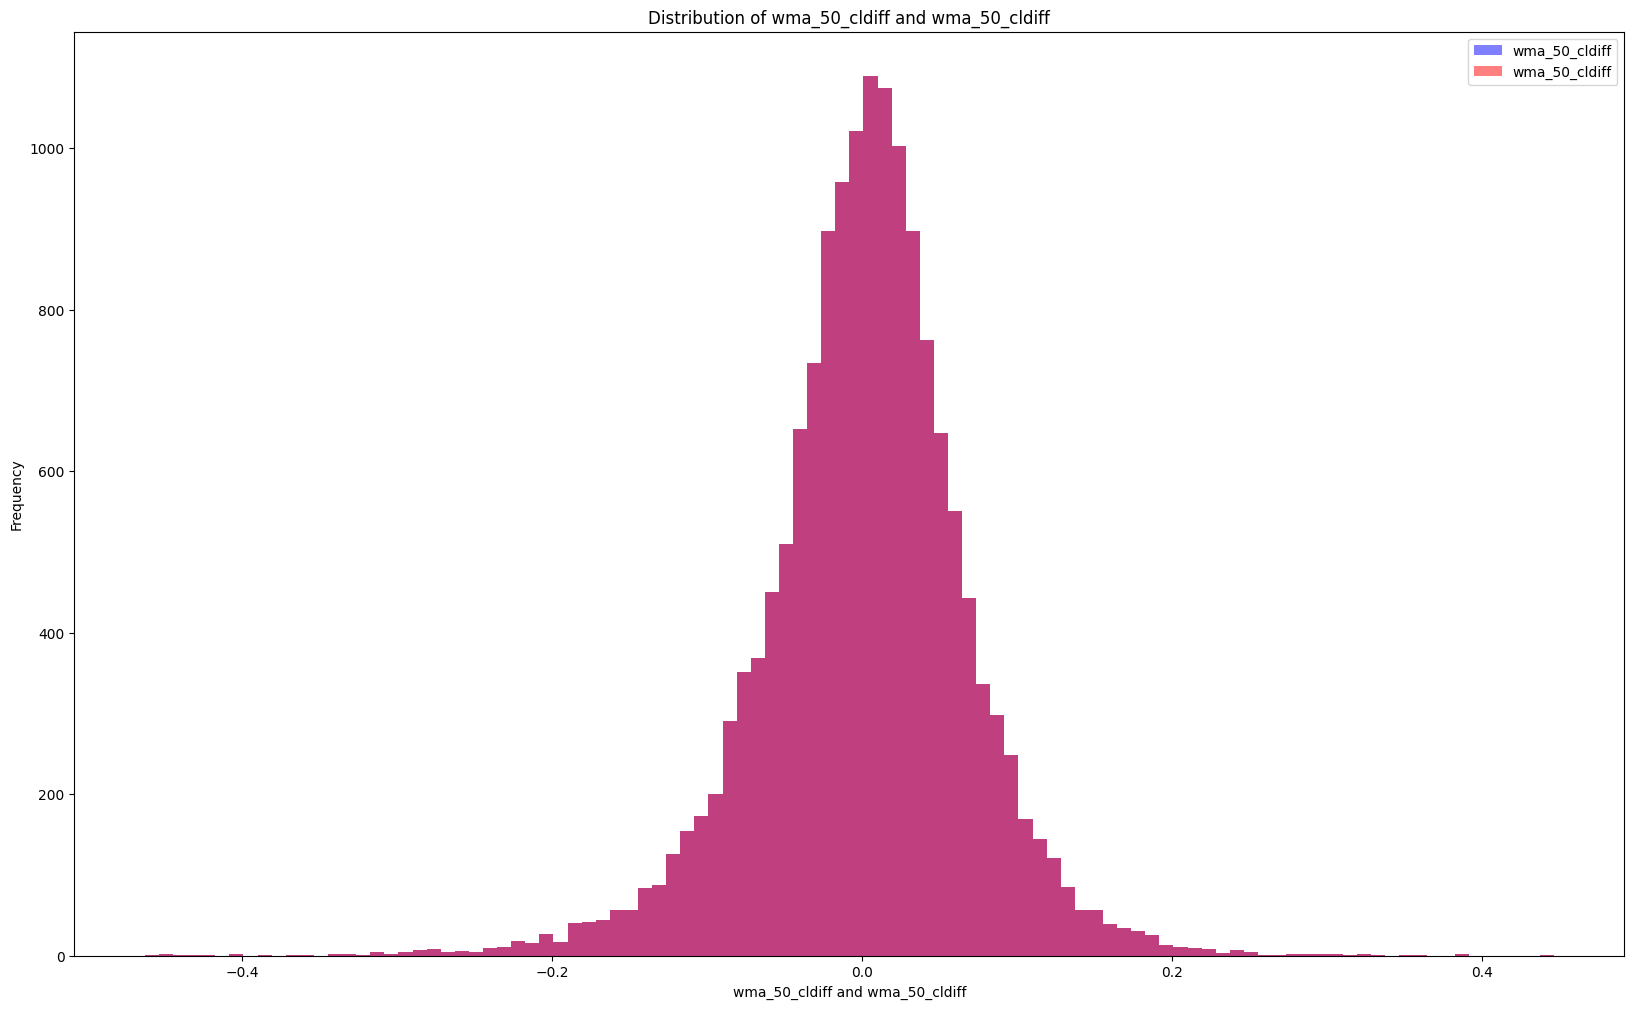

In [54]:
plot_dual_distributions(df, 'wma_50_cldiff', 'wma_50_cldiff')

In [55]:
df = df.copy()
df_dict = df_dict.copy()

## Signal Generation and Profit/Loss Calculation

*[Back to Table of Contents](#table-of-contents)*

This is where one should define any new strategy signal functions and call them on the ticker data.

In [56]:
# def trading_algorithm(data):
#     """
#     Trading algorithm to decide buy or not every 5 periods of 5-minute data.
    
#     Parameters:
#     - data (pd.DataFrame): A DataFrame with at least a 'close' column for the closing prices.
    
#     Returns:
#     - trades (list): A list of trade actions with entry price, stop-loss, take-profit, and decision details.
#     """
#     trades = []  # To store trade information
#     position_open = False
#     entry_price = 0
#     stop_loss = 0
#     take_profit = 0
    
#     # Calculate the 10-period moving average of the close price
#     data['ma_10'] = data['close'].rolling(window=10).mean()
    
#     # Calculate the first derivative of the 10-period moving average (rate of change)
#     data['ma_10_derivative'] = data['ma_10'].diff()
    
#     # Calculate the 5-period moving average of the first derivative
#     data['ma_10_derivative_ma_5'] = data['ma_10_derivative'].rolling(window=5).mean()
    
#     # Loop through the DataFrame in chunks of 5 periods
#     for i in range(5, len(data), 5):
#         # Get the current value of the 5-period moving average of the derivative
#         derivative_ma_5 = data['ma_10_derivative_ma_5'].iloc[i]
        
#         # If not in a position, make a decision to buy or not
#         if not position_open and derivative_ma_5 > 0:
#             # Buy decision: the derivative is positive
#             entry_price = data['close'].iloc[i]
#             stop_loss = entry_price * 0.95  # Stop-loss at 5% below entry price
#             take_profit = entry_price * 1.05  # Take-profit at 5% above entry price
#             position_open = True  # We are now in a position
            
#             trade_info = {
#                 'action': 'BUY',
#                 'entry_price': entry_price,
#                 'stop_loss': stop_loss,
#                 'take_profit': take_profit,
#                 'time': data.index[i]
#             }
#             trades.append(trade_info)
#             print(f"Trade executed: {trade_info}")
        
#         # If in a position, check stop-loss and take-profit conditions
#         if position_open:
#             current_price = data['close'].iloc[i]
#             if current_price <= stop_loss:
#                 # Trigger stop-loss
#                 trade_info = {
#                     'action': 'STOP-LOSS',
#                     'exit_price': current_price,
#                     'time': data.index[i]
#                 }
#                 trades.append(trade_info)
#                 position_open = False  # Close the position
#                 print(f"Trade executed: {trade_info}")
#             elif current_price >= take_profit:
#                 # Trigger take-profit
#                 trade_info = {
#                     'action': 'TAKE-PROFIT',
#                     'exit_price': current_price,
#                     'time': data.index[i]
#                 }
#                 trades.append(trade_info)
#                 position_open = False  # Close the position
#                 print(f"Trade executed: {trade_info}")
    
#     return trades

# # Function to simulate placing an order (replace this with real broker API calls)
# def place_order(symbol, side, quantity, price=None):
#     print(f"Placing {side} order for {quantity} {symbol} at {price if price else 'market price'}")
#     return price  # Simulated price (you could return the actual fill price from an API call)

# # Function to simulate stop-loss/take-profit logic
# def check_exit_conditions(entry_price, current_price, stop_loss, take_profit):
#     if current_price <= stop_loss:
#         return 'STOP_LOSS'
#     elif current_price >= take_profit:
#         return 'TAKE_PROFIT'
#     return None

# # Trading algorithm function
# def trading_algo(df, symbol, periods=5, stop_loss_pct=0.05, take_profit_pct=0.05):
#     position = None  # To track if a position is open (None means no position)
#     entry_price = None
#     stop_loss = None
#     take_profit = None
#     trade_counter = 0  # Counter to trigger trade decisions every 5 periods

#     for index, row in df.iterrows():
#         trade_counter += 1
        
#         # Check if it's time to make a decision (every 5 periods)
#         if trade_counter % periods == 0:
#             # Condition to buy (can be replaced with more complex logic)
#             if position is None:
#                 entry_price = row['close']  # Assuming we use the close price as entry
#                 stop_loss = entry_price * (1 - stop_loss_pct)
#                 take_profit = entry_price * (1 + take_profit_pct)

#                 # Simulate placing a buy order
#                 place_order(symbol, 'BUY', 1, entry_price)
#                 position = 'LONG'
#                 print(f"Entered position at {entry_price}, Stop Loss: {stop_loss}, Take Profit: {take_profit}")

#             trade_counter = 0  # Reset trade counter after decision

#         # If a position is open, monitor for stop-loss/take-profit conditions
#         if position == 'LONG':
#             exit_signal = check_exit_conditions(entry_price, row['close'], stop_loss, take_profit)

#             if exit_signal == 'STOP_LOSS':
#                 print(f"Stop Loss triggered at {row['close']}, exiting position.")
#                 place_order(symbol, 'SELL', 1, row['close'])
#                 position = None  # Close position
#             elif exit_signal == 'TAKE_PROFIT':
#                 print(f"Take Profit triggered at {row['close']}, exiting position.")
#                 place_order(symbol, 'SELL', 1, row['close'])
#                 position = None  # Close position

# # Sample DataFrame to simulate price data
# data = {
#     'datetime': pd.date_range(start='2024-09-12', periods=20, freq='5T'),  # 5-minute intervals
#     'close': [100, 102, 101, 103, 104, 106, 105, 107, 108, 110, 109, 111, 110, 112, 113, 115, 114, 116, 117, 119]
# }

# df = pd.DataFrame(data)

# # Run the trading algorithm
# trading_algo(df, symbol='/ES')


In [57]:
def check_moving_average(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi'):
    """
    Function to check if the moving average is above or below another moving average for each row.
    
    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): The column name for the first moving average (default is 'wma_5').
    - ma_name2 (str): The column name for the second moving average (default is 'sma_5').
    
    Returns:
    - candles (pd.DataFrame): The DataFrame with an updated 'signal' column.
    """
    current_time_USE = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S')
    current_hour = datetime.now(pytz.timezone('US/Eastern')).hour    
    current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
    current_second = datetime.now(pytz.timezone('US/Eastern')).second

    # Check if the moving average and RSI columns exist and have valid data
    if ma_name1 in candles.columns and ma_name2 in candles.columns:
        
        # Iterate through each row to compare the values of 'wma_5', 'sma_5'
        for i, row in candles.iterrows():
            # Check moving average condition
            if pd.notna(row[ma_name1]) and pd.notna(row[ma_name2]):
                if row[ma_name1] > row[ma_name2]:
                    candles.at[i, 'signal_ma'] = 1  # wma_5 is above sma_5
                    # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is ABOVE {ma_name2} {row[ma_name2]}, long entry")
                elif row[ma_name1] < row[ma_name2]:
                    candles.at[i, 'signal_ma'] = -1  # wma_5 is below sma_5
                    # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is BELOW {ma_name2} {row[ma_name2]}, long exit")
                else:
                    candles.at[i, 'signal_ma'] = 0  # wma_5 is equal to sma_5
                    # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is EQUAL to {ma_name2} {row[ma_name2]}, no signal")
            else:
                candles.at[i, 'signal_ma'] = 0  # If any data is missing, set signal to 0
                # print(f"{current_time_USE}: Insufficient data for {ma_name2} or {ma_name1} for index {i}")

    else:
        # If columns are missing, set the whole column to 0 (no signal)
        print(f"{current_time_USE}: Either {ma_name1} or {ma_name2} do not exist in {candles}")                

    if rsi_column in candles.columns:
            
        for i, row in candles.iterrows():    

            # Generate signals based on RSI
            if pd.notna(row[rsi_column]):
                if row[rsi_column] > 50:
                    candles.at[i, 'signal_rsi'] = 1  # RSI above 50
                    # print(f"{current_time_USE}: RSI {row[rsi_column]} is ABOVE 50, long entry")
                elif row[rsi_column] < 50:
                    candles.at[i, 'signal_rsi'] = -1  # RSI below 50
                    # print(f"{current_time_USE}: RSI {row[rsi_column]} is BELOW 50, long exit")
                elif row[rsi_column] == 50:
                    candles.at[i, 'signal_rsi'] = 0  # RSI at 50
                    # print(f"{current_time_USE}: RSI {row[rsi_column]} is EQUAL to 50, no signal")
            else:
                candles.at[i, 'signal_rsi'] = 0  # Handle missing data for RSI
                # print(f"{current_time_USE}: Insufficient data for {rsi_column} at index {i}")

    else:
        # If columns are missing, set the whole column to 0 (no signal)
        print(f"{current_time_USE}: {rsi_column} does not exist in {candles}")

    return candles

### Calling Signal and P/L Functions

Calling functions to calculate strategy signals and profit/loss for both `df` and `df_dict`. The strategy signal functions must be called before `calculate_position_percent_changes`, which must be called before `calculate_profit_loss_contributions` in order to get our P/L columns for everything as intended.

In [58]:
# df = generate_trading_signals(df, variables)

# for ticker in df_dict:
#     df_dict[ticker] = generate_trading_signals(df_dict[ticker], variables)

In [59]:
# df = generate_dynamic_trading_signals(df, variables)

# for ticker in df_dict:
#     df_dict[ticker] = generate_dynamic_trading_signals(df_dict[ticker], variables)

In [60]:
# df = generate_dynamic_trading_signals_2(df, variables)

# for ticker in df_dict:
#     df_dict[ticker] = generate_dynamic_trading_signals_2(df_dict[ticker], variables)

In [61]:
# df = generate_dynamic_trading_signals_3(df, variables)

# for ticker in df_dict:
#     df_dict[ticker] = generate_dynamic_trading_signals_3(df_dict[ticker], variables)

In [62]:
check_moving_average(df, ma_name1='wma_5', ma_name2='sma_5', rsi_column='RSI_5')

ticker    open    high     low   close  \
date_time                                                          
2020-01-02 09:30:00+00:00   MARA  0.8814  0.9013  0.8814  0.8914   
2020-01-02 10:00:00+00:00   MARA  0.8983  0.8983  0.8814  0.8945   
2020-01-02 10:30:00+00:00   MARA  0.8992  0.9000  0.8833  0.8900   
2020-01-02 11:00:00+00:00   MARA  0.8999  0.8999  0.8900  0.8997   
2020-01-02 11:30:00+00:00   MARA  0.8900  0.9100  0.8840  0.9050   
...                          ...     ...     ...     ...     ...   
2024-03-15 13:30:00+00:00   MARA 18.8650 19.0900 18.7700 19.0700   
2024-03-15 14:00:00+00:00   MARA 19.0800 19.4500 19.0650 19.3200   
2024-03-15 14:30:00+00:00   MARA 19.3100 19.8085 19.3100 19.7085   
2024-03-15 15:00:00+00:00   MARA 19.7100 19.8400 19.4900 19.6500   
2024-03-15 15:30:00+00:00   MARA 19.6500 19.6700 19.1600 19.3100   

                                  volume  year  month  day time_of_day  \
date_time                                                                
2020-01-02 09:30:00+00:00     3,266.0000  2020      1    2    09:30:00   
2020-01-02 10:00:00+00:00     6,420.0000  2020      1    2    10:00:00   
2020-01-02 10:30:00+00:00     6,438.0000  2020      1    2    10:30:00   
2020-01-02 11:00:00+00:00     7,575.0000  2020      1    2    11:00:00   
2020-01-02 11:30:00+00:00    43,321.0000  2020      1    2    11:30:00   
...                                  ...   ...    ...  ...         ...   
2024-03-15 13:30:00+00:00 2,057,746.0000  2024      3   15    13:30:00   
2024-03-15 14:00:00+00:00 3,017,587.0000  2024      3   15    14:00:00   
2024-03-15 14:30:00+00:00 4,010,413.0000  2024      3   15    14:30:00   
2024-03-15 15:00:00+00:00 3,904,448.0000  2024      3   15    15:00:00   
2024-03-15 15:30:00+00:00 4,613,982.0000  2024      3   15    15:30:00   

                           starting_cash  percent_change  pct_change_plus_1  \
date_time                                                                     
2020-01-02 09:30:00+00:00           1000             NaN                NaN   
2020-01-02 10:00:00+00:00           1000          0.0035             1.0035   
2020-01-02 10:30:00+00:00           1000         -0.0050             0.9950   
2020-01-02 11:00:00+00:00           1000          0.0109             1.0109   
2020-01-02 11:30:00+00:00           1000          0.0059             1.0059   
...                                  ...             ...                ...   
2024-03-15 13:30:00+00:00           1000          0.0107             1.0107   
2024-03-15 14:00:00+00:00           1000          0.0131             1.0131   
2024-03-15 14:30:00+00:00           1000          0.0201             1.0201   
2024-03-15 15:00:00+00:00           1000         -0.0030             0.9970   
2024-03-15 15:30:00+00:00           1000         -0.0173             0.9827   

                           cash_after_trade  cash_vertical  ohlc_avg   sma_1  \
date_time                                                                      
2020-01-02 09:30:00+00:00        1,003.4777         3.4777    0.8914  0.8914   
2020-01-02 10:00:00+00:00          994.9693        -5.0307    0.8914  0.8945   
2020-01-02 10:30:00+00:00        1,010.8989        10.8989    0.8911  0.8900   
2020-01-02 11:00:00+00:00        1,005.8909         5.8909    0.8965  0.8997   
2020-01-02 11:30:00+00:00        1,034.8066        34.8066    0.8997  0.9050   
...                                     ...            ...       ...     ...   
2024-03-15 13:30:00+00:00        1,013.1096        13.1096   18.9767 19.0700   
2024-03-15 14:00:00+00:00        1,020.1087        20.1087   19.2783 19.3200   
2024-03-15 14:30:00+00:00          997.0317        -2.9683   19.6090 19.7085   
2024-03-15 15:00:00+00:00          982.6972       -17.3028   19.6600 19.6500   
2024-03-15 15:30:00+00:00               NaN            NaN   19.3800 19.3100   

                            sma_2   sma_3   sma_4   sma_5   sma_6   sma_7  \
date_time                       

In [63]:
upper_triggers = list(range(20, 51, 5))
lower_triggers = list(range(-20, -51, -5))

# Apply the RSI state-based trading strategy for each combination of upper and lower triggers
for ut, lt in zip(upper_triggers, lower_triggers):
    suffix = f"ut{ut}_lt{lt}"
    df = rsi_trigger_based_trading(df, upper_trigger=ut, lower_trigger=lt, suffix=suffix)

for ticker in df_dict:
    for ut, lt in zip(upper_triggers, lower_triggers):
        suffix = f"ut{ut}_lt{lt}"
        df_dict[ticker] = rsi_trigger_based_trading(df_dict[ticker], upper_trigger=ut, lower_trigger=lt, suffix=suffix)

In [64]:
df = calculate_atr_statistics(df)

for ticker in df_dict:
    df_dict[ticker] = calculate_atr_statistics(df_dict[ticker])

Mean: 0.40956659711587545
Standard Deviation: 0.39320559365510294
1st Percentile: 0.013560000000000011
5th Percentile: 0.021895500000000023
10th Percentile: 0.034603500000000044
25th Percentile: 0.14362999999999992
50th Percentile (Median): 0.28028999999999993
75th Percentile: 0.5657225
90th Percentile: 0.9307459999999995
95th Percentile: 1.279190249999999
99th Percentile: 1.7680085999999995
Mode: 0.01666
Max: 2.808569999999999
Min: 0.006489999999999996
Mean: 0.20871713923872515
Standard Deviation: 0.06961879657013116
1st Percentile: 0.10904900000000041
5th Percentile: 0.12875
10th Percentile: 0.14011800000000071
25th Percentile: 0.16169499999999992
50th Percentile (Median): 0.19307999999999978
75th Percentile: 0.23944999999999936
90th Percentile: 0.29585000000000017
95th Percentile: 0.33495099999999994
99th Percentile: 0.45996739999999897
Mode: 0.16650000000000026
Max: 0.6649049999999992
Min: 0.08320500000000006
Mean: 0.15071644543828266
Standard Deviation: 0.11310198570986695
1st Per

In [65]:
short_mas = [f'wma_{i}' for i in range(1, 12, 2)]
long_mas = [f'wma_{i}' for i in range(10, 41, 5)]
atr_thresholds = [#'atr_percentile_1', 
                  'atr_percentile_5', 
                  'atr_percentile_10', 
                  'atr_percentile_25', 
                  'atr_percentile_50', 
                  'atr_percentile_75', 
                  'atr_percentile_90', 
                  'atr_percentile_95'#, 
                #   'atr_percentile_99'
                  ]

# Apply the hybrid strategy for each combination of short MA, long MA, and ATR threshold
for short_ma in short_mas:
    for long_ma in long_mas:
        for atr_threshold in atr_thresholds:
            df = hybrid_strategy(df, short_ma, long_ma, atr_threshold)

for ticker in df_dict:
    for short_ma in short_mas:
        for long_ma in long_mas:
            for atr_threshold in atr_thresholds:
                df_dict[ticker] = hybrid_strategy(df_dict[ticker], short_ma, long_ma, atr_threshold)

In [66]:
# df = transaction_counts(df)

# for ticker in df_dict:
#     df_dict[ticker] = transaction_counts(df_dict[ticker])

!!! Experimental parallel processing code:

In [67]:
# Experiment with parallel processing here...

!!! End experimental parallel processing code

In [68]:
df = calculate_position_percent_changes(df, 'close')

for ticker in df_dict:
    df_dict[ticker] = calculate_position_percent_changes(df_dict[ticker], 'close')

In [69]:
df = calculate_profit_loss_contributions(df)

for ticker in df_dict:
    df_dict[ticker] = calculate_profit_loss_contributions(df_dict[ticker])

In [70]:
df = df.copy()
df_dict = df_dict.copy()

Quality Check Tools

In [71]:
# def calc_manual(start_price, end_price):
#     percent_change = (end_price - start_price)/start_price
#     return percent_change

# calc_manual(8.12, 8.395)

# pd.set_option('display.max_rows', None)
# pd.options.display.float_format = '{:,.6f}'.format

# df[['close', 'wma_300_derivative_2', 'signal_wma_300_derivative_2', 'diff_signal_wma_300_derivative_2', 'position_percent_change_wma_300_derivative_2', 'RSI_14', 'signal_RSI_14_ut25_lt-25']][298:]

Check and make sure that the column names lists are all in the correct order and contain the same number of names !!!!!!!!!!!!!

In [72]:
# Assuming 'df' is your DataFrame
column_names = list(df.columns)  # Convert the Index object to a list

# Display all column names as a single string, separated by newlines
print("DataFrame Columns:\n" + "\n".join(column_names))

DataFrame Columns:
ticker
open
high
low
close
volume
year
month
day
time_of_day
starting_cash
percent_change
pct_change_plus_1
cash_after_trade
cash_vertical
ohlc_avg
sma_1
sma_2
sma_3
sma_4
sma_5
sma_6
sma_7
sma_8
sma_9
sma_10
sma_11
sma_12
sma_14
sma_16
sma_18
sma_20
sma_22
sma_24
sma_26
sma_28
sma_30
sma_32
sma_34
sma_36
sma_38
sma_40
sma_42
sma_44
sma_46
sma_48
sma_50
sma_15
sma_25
sma_21
sma_35
sma_60
sma_70
sma_80
sma_90
sma_100
sma_110
sma_120
sma_130
sma_140
sma_150
sma_160
sma_170
sma_180
sma_190
sma_200
sma_210
sma_220
sma_230
sma_240
sma_250
sma_260
sma_270
sma_280
sma_290
sma_300
wma_1
wma_2
wma_3
wma_4
wma_5
wma_6
wma_7
wma_8
wma_9
wma_10
wma_11
wma_12
wma_14
wma_16
wma_18
wma_20
wma_22
wma_24
wma_26
wma_28
wma_30
wma_32
wma_34
wma_36
wma_38
wma_40
wma_42
wma_44
wma_46
wma_48
wma_50
wma_15
wma_25
wma_21
wma_35
wma_60
wma_70
wma_80
wma_90
wma_100
wma_110
wma_120
wma_130
wma_140
wma_150
wma_160
wma_170
wma_180
wma_190
wma_200
wma_210
wma_220
wma_230
wma_240
wma_250
wma_260
w

In [73]:
# This is a start...
columns_gain_loss = [col for col in df.columns if col.startswith('profit_loss_')]
columns_diff = [col for col in df.columns if col.startswith('signal_')]
columns_position_percent_change = [col for col in df.columns if col.startswith('position_percent_change_')]

df_columns = pd.DataFrame({
    'columns_gain_loss': columns_gain_loss,
    'columns_diff': columns_diff,
    'columns_position_percent_change': columns_position_percent_change
})

In [74]:
df_columns

columns_gain_loss  \
0                                       profit_loss_ma   
1                                      profit_loss_rsi   
2                         profit_loss_RSI_3_ut20_lt-20   
3                         profit_loss_RSI_5_ut20_lt-20   
4                         profit_loss_RSI_7_ut20_lt-20   
..                                                 ...   
361  profit_loss_wma_11_X_wma_40_crossrev_atr_perce...   
362  profit_loss_wma_11_X_wma_40_crossrev_atr_perce...   
363  profit_loss_wma_11_X_wma_40_crossrev_atr_perce...   
364  profit_loss_wma_11_X_wma_40_crossrev_atr_perce...   
365  profit_loss_wma_11_X_wma_40_crossrev_atr_perce...   

                                          columns_diff  \
0                                            signal_ma   
1                                           signal_rsi   
2                              signal_RSI_3_ut20_lt-20   
3                              signal_RSI_5_ut20_lt-20   
4                              signal_RSI_7_ut20_lt-20   
..                                                 ...   
361  signal_wma_11_X_wma_40_crossrev_atr_percentile_25   
362  signal_wma_11_X_wma_40_crossrev_atr_percentile_50   
363  signal_wma_11_X_wma_40_crossrev_atr_percentile_75   
364  signal_wma_11_X_wma_40_crossrev_atr_percentile_90   
365  signal_wma_11_X_wma_40_crossrev_atr_percentile_95   

                       columns_position_percent_change  
0                           position_percent_change_ma  
1                          position_percent_change_rsi  
2             position_percent_change_RSI_3_ut20_lt-20  
3             position_percent_change_RSI_5_ut20_lt-20  
4             position_percent_change_RSI_7_ut20_lt-20  
..                                                 ...  
361  position_percent_change_wma_11_X_wma_40_crossr...  
362  position_percent_change_wma_11_X_wma_40_crossr...  
363  position_percent_change_wma_11_X_wma_40_crossr...  
364  position_percent_change_wma_11_X_wma_40_crossr...  
365  position_percent_change_wma_11_X_wma_40_crossr...  

[366 rows x 3 columns]

### Write Data to CSV and/or GBQ

Write data to .csv

In [75]:
# Write DataFrame to CSV file
# df.to_csv('base_features_with_derivatives.csv', index=False)
# Read CSV file into DataFrame
# df = pd.read_csv('base_features_with_derivatives.csv')

Write data to GBQ

In [76]:
# def write_df_to_gbq(df_dict, project_id, dataset_id, if_exists='replace'):
#     """
#     Writes the DataFrames in the dictionary to Google BigQuery.

#     Parameters:
#     - df_dict (dict): Dictionary of DataFrames to be written to BigQuery.
#     - project_id (str): Google Cloud project ID.
#     - dataset_id (str): BigQuery dataset ID.
#     - if_exists (str): Behavior when the table already exists. Default is 'replace'.
#                         Other options: 'fail', 'append'.

#     Returns:
#     None
#     """
#     for table_name, df in df_dict.items():
#         table_id = f"{dataset_id}.{table_name}"
#         print(f"Writing DataFrame to {table_id}...")
#         df.to_gbq(destination_table=table_id, project_id=project_id, if_exists=if_exists)
#         print(f"Successfully written {table_name} to BigQuery.")

# # Example usage:
# project_id = 'your_project_id'
# dataset_id = 'your_dataset_id'
# df_dict = {
#     'table1': pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]}),
#     'table2': pd.DataFrame({'x': [7, 8, 9], 'y': [10, 11, 12]})
# }

# write_df_to_gbq(df_dict, project_id, dataset_id)

## Visualizing Monthly CV Against Monthly Profit by Scatterplot

I believe the new strategy is being kicked out somewhere in here

*[Back to Table of Contents](#table-of-contents)*

### Scatterplot Function Variations for Dataframe Dictionaries

`calculate_monthly_stats_2` is a variation of `calculate_monthly_stats` that is built to calculate profit by month as well as monthly CV(price) and CV(volume) to visualize profit relationships via scatterplot.

`monthly_df_dict` will contain dataframes of all randomly selected tickers' monthly CVs and profit. For this table, I arbitrarily chose the 50 period wma from the wma second derivative group since they perform the highest, but no one of them always takes first place.

In [77]:
# # Indicator to visualize on profit to CV(price) scatterplot !!!
# indicator = 'wma_3_wma_20_crossrev'

# # Create the new dictionary of dataframes
# monthly_df_dict = {}

# # Iterate through df_dict and apply the calculate_monthly_stats_2 function
# for ticker, df in df_dict.items():
#     monthly_df_dict[ticker] = calculate_monthly_stats_2(df, 'M', indicator)

# # Example to print the keys of the new dictionary to confirm
# print(monthly_df_dict)

`plot_scatter_with_size_2` has some extra functionality such as the ability to choose whether to include a z-variable or set the x-axis scale. Most importantly, we can now color code the data points on the scatter plot according to which ticker they belong to.

### Ticker-Month CV(price) vs Mean Price Scatterplot

The first plot specifies no x-axis right bound so we can see the included data in its entirety. The correlation between `monthly_profit` and `cv_close` seems to be generally positive with some variance that may be explained in the future by some currently exongenous variable(s). The next few plots manipulate the x-axis so we can see deeper into the data that is obscurred by crowding in the first.

In [78]:
# plot_scatter_with_size_2(monthly_df_dict, 'monthly_profit', 'cv_close', 'mean_close')

The next invocation pulls the scale in a bit so we can see more of what's happening in the concentrated areas of the data. If you look carefully, you can see that some tickers' months exhibit characteristics as a group relative to the other groups. It's not a terrible thing to see a pattern like this since we're trying to develop predictive capacity in rifling through all this data.

In [79]:
# plot_scatter_with_size_2(monthly_df_dict, 'monthly_profit', 'cv_close', 'mean_close', 6000)

Looking even closer into the concentrated area of data points.

In [80]:
# plot_scatter_with_size_2(monthly_df_dict, 'monthly_profit', 'cv_close', 'mean_close', 1500)

## Performance Summaries

*[Back to Table of Contents](#table-of-contents)*

### Permormance Summary Function

The next section of code creates tables of the performance summary statistics of all strategies for which there are existing signal column. It's here that we can navigate through all strategies by these statistics and choose which ones might be worth exploring further.
* Think about calculating profit per hour, day, week, month, year

In [81]:
# df[['close', 'percent_change', 'cash_vertical', 'wma_300', 'wma_300_derivative_1', 'wma_300_derivative_2', 'signal_wma_300_derivative_2', 'position_percent_change_wma_300_derivative_2', 'profit_loss_wma_300_derivative_2']][299:350]

### Calling Performance Summary Function

Calling `create_sum_dataframe` on the singular dataframe `df` and the dictionary of random tickers `df_dict`. The former invocation will result in a new dataframe of performance summaries for the one ticker and the latter will create a dictionary of all tickers' performance summary tables.

In [82]:
# Create the sum DataFrame
performance_df = create_sum_dataframe(df, 'cash_vertical')

# Create a new dictionary to store the result DataFrames
performance_df_dict = {}

# Iterate through the dictionary of DataFrames and apply the `create_sum_dataframe` function
for ticker in df_dict:
    performance_name = f'{ticker}'
    performance_df_dict[performance_name] = create_sum_dataframe(df_dict[ticker], 'cash_vertical')

Total close-to-close verticality for MARA is 222218.83276961587
Total close-to-close verticality for GFL is 55711.30544359491
Total close-to-close verticality for IREN is 118780.19938425685
Total close-to-close verticality for EXTR is 87069.286035107
Total close-to-close verticality for ARRY is 102907.22796684378
Total close-to-close verticality for UA is 78121.8516794228
Total close-to-close verticality for PEB is 81353.6074197371
Total close-to-close verticality for WRK is 58273.00824199458
Total close-to-close verticality for GFAI is 190784.17940231806
Total close-to-close verticality for HIMS is 101850.13629501485
Total close-to-close verticality for VFS is 28877.286930617192


CV_VOLUME IS DIFFERENT HERE THAN IT IS IN `all_tickers`. Why?

In [83]:
performance_df['cv_close_price'] = df['close'].std() / df['close'].mean()
performance_df['cv_volume'] = df['volume'].std() / df['volume'].mean()

for ticker in df_dict:
    performance_df_dict[ticker]['cv_close_price'] = df_dict[ticker]['close'].std() / df_dict[ticker]['close'].mean()
    performance_df_dict[ticker]['cv_volume'] = df_dict[ticker]['volume'].std() / df_dict[ticker]['volume'].mean()

In [84]:
# ticker_test = 'BA'
# print(df_dict[ticker_test]['close'].std() / df_dict[ticker_test]['close'].mean())
# print(df_dict[ticker_test]['volume'].std() / df_dict[ticker_test]['volume'].mean())

In [85]:
# all_tickers[all_tickers['ticker'] == ticker_test]

### Performance Tables

In [86]:
# Sorting all ticker dfs
performance_df = performance_df.sort_values(by='Profit', ascending=False)
performance_df.reset_index(drop=True, inplace=True)
# performance_df.style.set_sticky()

for ticker in performance_df_dict:
    performance_df_dict[ticker] = performance_df_dict[ticker].sort_values(by='Profit', ascending=False)
    performance_df_dict[ticker].reset_index(drop=True, inplace=True)
    # performance_df_dict[ticker].style.set_sticky()

In [87]:
# Display options
pd.options.display.float_format = '{:,.2f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
# pd.reset_option('display.max_rows') # Display default abbreviated rows

performance_df

Ticker                                   Indicator     Profit  Trades  Profit_Per_Trade  Adjusted_Low_50  Adjusted_Mid_70  Adjusted_High_90  Winning_Longs  Losing_Longs  Winning_Shorts  Losing_Shorts  Max_Drawdown  Intratrade_Max_Drawdown  Periods_Long  Periods_Neutral  Periods_Short  Captured_Verticality  Avg_Long_Duration  Avg_Short_Duration  Avg_Neutral_Duration  cv_close_price  cv_volume
0     MARA   wma_1_X_wma_10_crossrev_atr_percentile_25  10,459.48    4824              2.17         5,229.74         7,321.64          9,413.53            883          1001             924            963      2,437.38                 2,452.69          7302             1067           7322                  0.05               7.50                7.50                  5.00            0.87       1.46
1     MARA   wma_1_X_wma_10_crossrev_atr_percentile_90  10,390.33    4792              2.17         5,195.17         7,273.23          9,351.30           1176           711            1199            653      1,216.36                 1,227.75          7541             1067           7083                  0.05               7.50                7.50                  5.00            0.87       1.46
2     MARA   wma_1_X_wma_10_crossrev_atr_percentile_75   9,704.93    4866              1.99         4,852.47         6,793.45          8,734.44           1139           787            1149            738      1,336.78                 1,317.16          7569             1067           7055                  0.04               7.50                7.50                  5.00            0.87       1.46
3     MARA   wma_1_X_wma_10_crossrev_atr_percentile_95   9,692.52    4770              2.03         4,846.26         6,784.76          8,723.27           1191           680            1216            630      1,623.41                 1,612.12          7575             1067           7049                  0.04               7.50                7.50                  5.00            0.87       1.46
4     MARA   wma_1_X_wma_15_crossrev_atr_percentile_25   9,672.08    4250              2.28         4,836.04         6,770.45          8,704.87            756           846             792            804      1,067.21                 1,096.10          7331             1071           7289                  0.04               7.50                7.50                  7.50            0.87       1.46
5     MARA   wma_1_X_wma_20_crossrev_atr_percentile_25   9,442.70    3890              2.43         4,721.35         6,609.89          8,498.43            667           759             709            703      1,144.22                 1,191.13          7334             1076           7281                  0.04               7.50                7.50                 10.00            0.87       1.46
6     MARA   wma_1_X_wma_15_crossrev_atr_percentile_90   8,666.12    4233              2.05         4,333.06         6,066.28          7,799.51           1008           607            1025            541      1,482.30                 1,504.96          7600             1071           7020                  0.04               7.50                7.50                  7.50            0.87       1.46
7     MARA   wma_1_X_wma_15_crossrev_atr_percentile_95   8,253.55    4213              1.96         4,126.77         5,777.48          7,428.19           1020           583            1037            521      1,689.46                 1,688.62          7656             1071           6964                  0.04               7.50                7.50                  7.50            0.87       1.46
8     MARA   wma_3_X_wma_20_crossrev_atr_percentile_10   8,089.10    3212              2.52         4,044.55         5,662.37          7,280.19            483           588             539            550        838.50                   872.74          7044             1076           7571                  0.04               7.50                7.50                 10.00            0.87       1.46
9     MARA   w

In [88]:
performance_df[~performance_df['Indicator'].str.contains('true_derivative_')]

Ticker                                   Indicator     Profit  Trades  Profit_Per_Trade  Adjusted_Low_50  Adjusted_Mid_70  Adjusted_High_90  Winning_Longs  Losing_Longs  Winning_Shorts  Losing_Shorts  Max_Drawdown  Intratrade_Max_Drawdown  Periods_Long  Periods_Neutral  Periods_Short  Captured_Verticality  Avg_Long_Duration  Avg_Short_Duration  Avg_Neutral_Duration  cv_close_price  cv_volume
0     MARA   wma_1_X_wma_10_crossrev_atr_percentile_25  10,459.48    4824              2.17         5,229.74         7,321.64          9,413.53            883          1001             924            963      2,437.38                 2,452.69          7302             1067           7322                  0.05               7.50                7.50                  5.00            0.87       1.46
1     MARA   wma_1_X_wma_10_crossrev_atr_percentile_90  10,390.33    4792              2.17         5,195.17         7,273.23          9,351.30           1176           711            1199            653      1,216.36                 1,227.75          7541             1067           7083                  0.05               7.50                7.50                  5.00            0.87       1.46
2     MARA   wma_1_X_wma_10_crossrev_atr_percentile_75   9,704.93    4866              1.99         4,852.47         6,793.45          8,734.44           1139           787            1149            738      1,336.78                 1,317.16          7569             1067           7055                  0.04               7.50                7.50                  5.00            0.87       1.46
3     MARA   wma_1_X_wma_10_crossrev_atr_percentile_95   9,692.52    4770              2.03         4,846.26         6,784.76          8,723.27           1191           680            1216            630      1,623.41                 1,612.12          7575             1067           7049                  0.04               7.50                7.50                  5.00            0.87       1.46
4     MARA   wma_1_X_wma_15_crossrev_atr_percentile_25   9,672.08    4250              2.28         4,836.04         6,770.45          8,704.87            756           846             792            804      1,067.21                 1,096.10          7331             1071           7289                  0.04               7.50                7.50                  7.50            0.87       1.46
5     MARA   wma_1_X_wma_20_crossrev_atr_percentile_25   9,442.70    3890              2.43         4,721.35         6,609.89          8,498.43            667           759             709            703      1,144.22                 1,191.13          7334             1076           7281                  0.04               7.50                7.50                 10.00            0.87       1.46
6     MARA   wma_1_X_wma_15_crossrev_atr_percentile_90   8,666.12    4233              2.05         4,333.06         6,066.28          7,799.51           1008           607            1025            541      1,482.30                 1,504.96          7600             1071           7020                  0.04               7.50                7.50                  7.50            0.87       1.46
7     MARA   wma_1_X_wma_15_crossrev_atr_percentile_95   8,253.55    4213              1.96         4,126.77         5,777.48          7,428.19           1020           583            1037            521      1,689.46                 1,688.62          7656             1071           6964                  0.04               7.50                7.50                  7.50            0.87       1.46
8     MARA   wma_3_X_wma_20_crossrev_atr_percentile_10   8,089.10    3212              2.52         4,044.55         5,662.37          7,280.19            483           588             539            550        838.50                   872.74          7044             1076           7571                  0.04               7.50                7.50                 10.00            0.87       1.46
9     MARA   w

In [89]:
print(performance_df_dict.keys())

dict_keys(['GFL', 'IREN', 'EXTR', 'ARRY', 'UA', 'PEB', 'WRK', 'GFAI', 'HIMS', 'VFS'])


In [90]:
performance_df_dict[keys[0]][~performance_df_dict[keys[0]]['Indicator'].str.contains('true_derivative_')]

Ticker                                   Indicator    Profit  Trades  Profit_Per_Trade  Adjusted_Low_50  Adjusted_Mid_70  Adjusted_High_90  Winning_Longs  Losing_Longs  Winning_Shorts  Losing_Shorts  Max_Drawdown  Intratrade_Max_Drawdown  Periods_Long  Periods_Neutral  Periods_Short  Captured_Verticality  Avg_Long_Duration  Avg_Short_Duration  Avg_Neutral_Duration  cv_close_price  cv_volume
0      GFL                           RSI_19_ut40_lt-40  1,174.80      76             15.46           587.40           822.36          1,057.32              9             9              11             10        363.92                   438.46          7014              106           7112                  0.02             438.19              355.50                  4.75            0.21       1.55
1      GFL                           RSI_17_ut45_lt-45  1,128.97      24             47.04           564.48           790.28          1,016.07              4             2               4              2        281.97                   575.15          6534               33           7665                  0.02           1,089.00            1,277.50                  4.40            0.21       1.55
2      GFL  wma_11_X_wma_10_crossrev_atr_percentile_50    869.82    3476              0.25           434.91           608.87            782.84            616           638             598            616        592.47                   594.70          6914             1027           6291                  0.02               7.50                7.50                  4.33            0.21       1.55
3      GFL  wma_11_X_wma_10_crossrev_atr_percentile_10    828.15    3234              0.26           414.07           579.70            745.33            616           497             611            502        529.88                   529.88          6575             1027           6630                  0.01               7.50                7.50                  4.33            0.21       1.55
4      GFL  wma_11_X_wma_10_crossrev_atr_percentile_25    825.50    3461              0.24           412.75           577.85            742.95            643           596             626            588        529.96                   544.65          6735             1027           6470                  0.01               7.50                7.50                  4.33            0.21       1.55
5      GFL   wma_11_X_wma_10_crossrev_atr_percentile_5    817.45    3147              0.26           408.73           572.22            735.71            594           472             589            484        531.15                   531.15          6531             1027           6674                  0.01               7.50                7.50                  4.33            0.21       1.55
6      GFL                           RSI_13_ut45_lt-45    767.50      87              8.82           383.75           537.25            690.75             13             7              12             12        359.52                   520.21          6035              102           8095                  0.01             317.58              337.29                  4.57            0.21       1.55
7      GFL                            RSI_9_ut40_lt-40    765.35     771              0.99           382.68           535.75            688.82             94            90              90            114        390.71                   428.19          6100              969           7163                  0.01              48.31               61.81                  6.50            0.21       1.55
8      GFL                           RSI_21_ut45_lt-45    663.92       8             82.99           331.96           464.74            597.52              2             0               1              1        227.86                   528.30         10598               15           3619                  0.01           5,299.00            1,809.50                  3.75            0.21       1.55
9      GFL              

### CV(price) to Profit Scatterplot

In [91]:
# indicator_value = 'wma_2_shifted_derivative_1'
# profit_cv_df = build_profit_cv_df(df, performance_df_dict, indicator_value)
# profit_cv_df

In [92]:
# plot_scatter_with_size(profit_cv_df, 'cv_close_price', 'Profit', 'cv_volume')

### Run-time, Stopper, Display Reset 

In [93]:
# Display options
# pd.options.display.float_format = '{:,.2f}'.format # Format numerical output to have certain number of decimals
pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

In [94]:
# The amount of time elapsed so far
end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 480.38 seconds


Stops the script from going on to visualization and reset display options.

In [95]:
# stop =

## Profit Curve and Trade Visualizations

*[Back to Table of Contents](#table-of-contents)*

### Cumulative Profit Curves

In [96]:
# cumulative_profit_chart_2(df_viz, 'intratrade_profit_loss_', 'wma_', 'derivative_2', x_axis=10, y_axis=6)

In [97]:
# cumulative_profit_chart_2(df_viz, 'intratrade_profit_loss_', 'RSI_', '', x_axis=10, y_axis=6)

### Trade Visualization

Creating a function for visualizing a trade session and accompanying indicators.

* Smoothing some indicators to eliminate some noise from them.

In [98]:
# df

In [99]:
# # Apply smoothing to multiple columns
# smooth_columns = ['momentum_5_derivative_1', 'sqz_derivative_1', 'RSI_14']
# for col in smooth_columns:
#     df = smooth_column(df, col, window_size=2)

In [100]:
df_viz = df.copy()
df_dict_viz = df_dict.copy()

In [101]:
# def plot_for_trading_day(df, trading_day, start_time='09:30', end_time='16:00'):
#     """
#     Plots an OHLC candlestick chart for a given trading day with various technical indicators.
#     This includes VWAP, Simple Moving Averages (SMAs), VWAP bands, pivot points, RSI on a separate panel,
#     flux capacitor indicators, buy and sell signals, and the 'SQZ_20_2.0_20_1.5' indicator on a new panel.
    
#     Parameters:
#     - df (pd.DataFrame): The DataFrame containing the trading data.
#     - trading_day (str): The trading day to visualize in 'YYYY-MM-DD' format.
#     - start_time (str): The start time for the trading day visualization.
#     - end_time (str): The end time for the trading day visualization.
#     """
    
#     df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    
#     trading_day = pd.to_datetime(trading_day).date()
#     df_day = df[df.index.date == trading_day]
#     df_timeframe = df_day.between_time(start_time, end_time)

#     add_plots = [mpf.make_addplot(df_timeframe['vwap'], color='blue', width=1)]

#     sma_colors = ['purple', 'purple', 'purple', 'purple', 'purple']
#     sma_columns = ['sma_10', 'sma_20', 'sma_30', 'sma_40', 'sma_50']
#     for sma, color in zip(sma_columns, sma_colors):
#         add_plots.append(mpf.make_addplot(df_timeframe[sma], color=color, width=0.5))

#     vwap_bands = ['vwap_band_1_up', 'vwap_band_1_down', 'vwap_band_2_up', 'vwap_band_2_down', 'vwap_band_3_up', 'vwap_band_3_down']
#     pivot_points = ['pivot_point', 'r1', 's1', 'r2', 's2', 'r3', 's3']
#     colors = ['grey'] * len(vwap_bands) + ['black', 'red', 'green', 'red', 'green', 'red', 'green']
#     for feature, color in zip(vwap_bands + pivot_points, colors):
#         add_plots.append(mpf.make_addplot(df_timeframe[feature], color=color, width=0.75))

#     # Custom function to determine the color of the histogram bars for 'momentum'
#     def momentum_color(momentum_values):
#         return ['green' if val > 0 else 'red' for val in momentum_values]

#     # Visualization for 'momentum' as a histogram on the same panel
#     momentum_plot = mpf.make_addplot(
#         df_timeframe['momentum_5'], 
#         panel=3, 
#         type='bar', 
#         color=momentum_color(df_timeframe['momentum_5']), 
#         ylabel='Momentum'
#     )

#     # Visualization for 'derivative_one_momentum' as a black line on the same panel as 'momentum'
#     derivative_one_momentum_plot = mpf.make_addplot(df_timeframe['momentum_5_derivative_1']*2, panel=3, color='black', width=1.0, secondary_y=False)
#     smooth_derivative_one_momentum_plot = mpf.make_addplot(df_timeframe['smooth_momentum_5_derivative_1']*2, panel=3, color='grey', width=1.0, secondary_y=False)
#     derivative_two_momentum_plot = mpf.make_addplot(df_timeframe['momentum_5_derivative_2']*3, panel=3, color='purple', width=1.0, secondary_y=False)    
#     add_plots.append(derivative_one_momentum_plot)
#     add_plots.append(smooth_derivative_one_momentum_plot)    
#     add_plots.append(derivative_two_momentum_plot)    
#     add_plots.append(momentum_plot)

#     # Custom function to determine the color of the histogram bars for 'momentum'
#     def sqz_color(sqz_values):
#         return ['blue' if val > 0 else 'darkorange' for val in sqz_values]

#     # Visualization for 'sqz' as a histogram on the same panel
#     sqz_plot = mpf.make_addplot(
#         df_timeframe['sqz'], 
#         panel=2, 
#         type='bar', 
#         color=sqz_color(df_timeframe['sqz']), 
#         ylabel='SQZ'
#     )

#     # Visualization for 'derivative_one_sqz' as a black line on the same panel as 'sqz'
#     derivative_one_sqz_plot = mpf.make_addplot(df_timeframe['sqz_derivative_1']*4, panel=2, color='brown', width=1.0, secondary_y=False)
#     smooth_derivative_one_sqz_plot = mpf.make_addplot(df_timeframe['smooth_sqz_derivative_1']*4, panel=2, color='blue', width=1.0, secondary_y=False)
#     add_plots.append(derivative_one_sqz_plot)
#     add_plots.append(smooth_derivative_one_sqz_plot)    
    
#     add_plots.append(sqz_plot)    

#     # # Visualization for 'grad' as a black line on the same panel as 'SQZ_20_2.0_20_1.5'
#     # grad_plot = mpf.make_addplot(df_timeframe['grad']*4, panel=2, color='black', width=1.0, secondary_y=False)
#     # smooth_grad_plot = mpf.make_addplot(df_timeframe['smooth_grad']*4, panel=2, color='grey', width=1.0, secondary_y=False)
#     # add_plots.append(grad_plot)
#     # add_plots.append(smooth_grad_plot)
    
#     marsod_plot = mpf.make_addplot(df_timeframe['marsod_5'], panel=4, color='red', ylabel='MARSOD')
#     weighted_marsod_plot = mpf.make_addplot(df_timeframe['weighted_marsod_5'], panel=4, color='orange')
#     add_plots.append(marsod_plot)
#     add_plots.append(weighted_marsod_plot)

#     # Ensure the zero_line array is correctly aligned with the DataFrame index
#     zero_line = pd.Series(0, index=df_timeframe.index)
#     zero_line_plot = mpf.make_addplot(zero_line, panel=4, color='black', width=1.0, linestyle='--', ylabel='')
#     add_plots.append(zero_line_plot)   
        
#     rsi_plot = mpf.make_addplot(df_timeframe['RSI_14'], panel=5, color='black', ylabel='RSI')
#     smooth_rsi_plot = mpf.make_addplot(df_timeframe['smooth_RSI_14'], panel=5, color='purple')    
#     add_plots.append(rsi_plot)
#     add_plots.append(smooth_rsi_plot)

#     # RSI levels and corresponding colors 
#     rsi_levels = [-50, -25, -20, 0, 20, 25, 50]
#     level_colors = {
#         -50: 'green',
#         -25: 'green',
#         -20: 'green',
#         0: 'black',
#         20: 'red',
#         25: 'red',
#         50: 'red'
#     }

#     # Add horizontal lines at specified RSI levels with defined colors
#     for level in rsi_levels:
#         color = level_colors.get(level, 'blue')  # Default color is blue
#         hline = mpf.make_addplot(
#             np.array([level for _ in range(len(df_timeframe))]),  # Array with constant value 'level'
#             panel=5, 
#             color=color,  # Use the color mapped to the level
#             width=0.5, 
#             linestyle='--', 
#             ylim=(-2, 101)
#         )
#         add_plots.append(hline)

#     df_timeframe['Buy_Price'] = np.where(df_timeframe['Buy'], df_timeframe['Close'], np.nan)
#     df_timeframe['Sell_Price'] = np.where(df_timeframe['Sell'], df_timeframe['Close'], np.nan)

#     buy_scatter = mpf.make_addplot(df_timeframe['Buy_Price'], type='scatter', markersize=50, marker='^', color='black')
#     sell_scatter = mpf.make_addplot(df_timeframe['Sell_Price'], type='scatter', markersize=50, marker='v', color='red')

#     add_plots.extend([buy_scatter, sell_scatter])    

#     # Define buy and sell prices for SQZ indicator
#     df_timeframe['SQZ_Buy_Price'] = np.where(df_timeframe['Buy'], df_timeframe['SQZ_20_2.0_20_1.5'], np.nan)
#     df_timeframe['SQZ_Sell_Price'] = np.where(df_timeframe['Sell'], df_timeframe['SQZ_20_2.0_20_1.5'], np.nan)

#     # Create scatter plots for buy and sell signals on the SQZ panel
#     sqz_buy_scatter = mpf.make_addplot(df_timeframe['SQZ_Buy_Price'], panel=2, type='scatter', markersize=50, marker='^', color='black', secondary_y=True)
#     sqz_sell_scatter = mpf.make_addplot(df_timeframe['SQZ_Sell_Price'], panel=2, type='scatter', markersize=50, marker='v', color='red', secondary_y=True)

#     # Now, instead of adding the undefined momentum_buy_scatter and momentum_sell_scatter,
#     # let's add our newly defined sqz_buy_scatter and sqz_sell_scatter to the add_plots list
#     add_plots.extend([sqz_buy_scatter, sqz_sell_scatter])

#     mpf.plot(df_timeframe, type='candle', style='charles',
#              title=f"OHLC Candlestick Chart with Technical Indicators for {trading_day}",
#              addplot=add_plots,
#              figratio=(36, 24),
#              figscale=2.5,
#              volume=True,
#              volume_panel=1,
#              panel_ratios=(8, 2, 2, 2, 2, 2),  # Adjust panel_ratios to accommodate new SQZ panel
#              mav=(10, 20, 30, 40, 50),
#              show_nontrading=False,
#              tight_layout=True)

In [102]:
# Adjust the example usage to match your DataFrame and trading day
# plot_for_trading_day(df_viz, '2023-02-03', '09:30', '16:00')

In [103]:
# df_viz.dropna(inplace=True)

In [104]:
df_viz[['vwap_band_3_up', 'vwap_band_2_up', 'vwap_band_1_up', 'vwap', 'vwap_band_1_down', 'vwap_band_2_down', 'vwap_band_3_down']][1100:1125]

vwap_band_3_up  vwap_band_2_up  vwap_band_1_up      vwap  vwap_band_1_down  vwap_band_2_down  vwap_band_3_down
date_time                                                                                                                                
2020-04-29 13:30:00+00:00        0.534665        0.526247        0.517829  0.509412          0.500994          0.492576          0.484158
2020-04-29 14:00:00+00:00        0.539150        0.528821        0.518493  0.508164          0.497835          0.487507          0.477178
2020-04-29 14:30:00+00:00        0.543205        0.531302        0.519400  0.507498          0.495596          0.483694          0.471792
2020-04-29 15:00:00+00:00        0.546339        0.532667        0.518995  0.505323          0.491651          0.477979          0.464307
2020-04-29 15:30:00+00:00        0.551056        0.535194        0.519331  0.503469          0.487607          0.471744          0.455882
2020-04-29 16:00:00+00:00        0.555278        0.537991        0.520704  0.503418          0.486131          0.468844          0.451558
2020-04-29 16:30:00+00:00        0.558576        0.540133        0.521691  0.503248          0.484806          0.466363          0.447920
2020-04-30 09:30:00+00:00             NaN             NaN             NaN  0.457933               NaN               NaN               NaN
2020-04-30 10:00:00+00:00        0.473620        0.467632        0.461643  0.455655          0.449667          0.443678          0.437690
2020-04-30 10:30:00+00:00        0.468410        0.463987        0.459564  0.455141          0.450718          0.446295          0.441872
2020-04-30 11:00:00+00:00        0.473115        0.466480        0.459844  0.453209          0.446573          0.439937          0.433302
2020-04-30 11:30:00+00:00        0.470720        0.464696        0.458672  0.452648          0.446624          0.440600          0.434576
2020-04-30 12:00:00+00:00        0.470117        0.464231        0.458346  0.452461          0.446575          0.440690          0.434805
2020-04-30 12:30:00+00:00        0.472175        0.465284        0.458393  0.451503          0.444612          0.437721          0.430830
2020-04-30 13:00:00+00:00        0.476506        0.468141        0.459777  0.451413          0.443048          0.434684          0.426319
2020-04-30 13:30:00+00:00        0.478511        0.469268        0.460026  0.450783          0.441540          0.432298          0.423055
2020-04-30 14:00:00+00:00        0.480634        0.470488        0.460341  0.450194          0.440048          0.429901          0.419754
2020-04-30 14:30:00+00:00        0.480584        0.470293        0.460001  0.449710          0.439419          0.429128          0.418837
2020-04-30 15:00:00+00:00        0.479312        0.469377        0.459441  0.449506          0.439571          0.429635          0.419700
2020-04-30 15:30:00+00:00        0.478076        0.468562        0.459049  0.449536          0.440022          0.430509          0.420995
2020-04-30 16:00:00+00:00        0.477593        0.468242        0.458890  0.449538          0.440187          0.430835          0.421484
2020-05-01 09:30:00+00:00             NaN             NaN             NaN  0.443567               NaN               NaN               NaN
2020-05-01 10:00:00+00:00        0.446072        0.445403        0.444733  0.444064          0.443394          0.442725          0.442055
2020-05-01 10:30:00+00:00        0.450864        0.448493        0.446123  0.443752          0.441381          0.439010          0.436640
2020-05-01 11:00:00+00:00        0.449856        0.447639        0.445422  0.443205          0.440988          0.438771          0.436554

### Newest Trade Plot

In [105]:
print(df_dict.keys())
print(df.index.min())
print(df.index.max())

dict_keys(['GFL', 'IREN', 'EXTR', 'ARRY', 'UA', 'PEB', 'WRK', 'GFAI', 'HIMS', 'VFS'])
2020-01-02 09:30:00+00:00
2024-03-15 15:30:00+00:00


You changed ATR period to 5 !!!!!!!!!!!!!!!! Maybe flip the ATR rule... Try ATR at 10... 14 and 25

In [106]:
df_viz

ticker     open     high      low    close     volume  year  month  day time_of_day  starting_cash  percent_change  pct_change_plus_1  cash_after_trade  cash_vertical   ohlc_avg    sma_1     sma_2      sma_3      sma_4     sma_5      sma_6      sma_7      sma_8      sma_9    sma_10     sma_11     sma_12     sma_14     sma_16     sma_18     sma_20     sma_22     sma_24     sma_26     sma_28     sma_30     sma_32     sma_34     sma_36     sma_38     sma_40     sma_42     sma_44     sma_46     sma_48     sma_50     sma_15     sma_25     sma_21     sma_35     sma_60     sma_70     sma_80     sma_90    sma_100    sma_110    sma_120    sma_130    sma_140    sma_150    sma_160    sma_170    sma_180    sma_190    sma_200    sma_210    sma_220    sma_230    sma_240    sma_250    sma_260    sma_270    sma_280    sma_290    sma_300    wma_1      wma_2      wma_3     wma_4      wma_5      wma_6      wma_7      wma_8      wma_9     wma_10     wma_11     wma_12     wma_14     wma_16     wma_18     wma_20     wma_22     wma_24     wma_26     wma_28     wma_30     wma_32     wma_34     wma_36     wma_38     wma_40     wma_42     wma_44     wma_46     wma_48     wma_50     wma_15     wma_25     wma_21     wma_35     wma_60     wma_70     wma_80     wma_90    wma_100    wma_110    wma_120    wma_130    wma_140    wma_150    wma_160    wma_170    wma_180    wma_190    wma_200    wma_210    wma_220    wma_230    wma_240    wma_250    wma_260    wma_270    wma_280    wma_290    wma_300  marsod_1  marsod_2  marsod_3  marsod_5  marsod_7  marsod_10  weighted_marsod_1  weighted_marsod_2  weighted_marsod_3  weighted_marsod_5  weighted_marsod_7  weighted_marsod_10       sqz      RSI_3      RSI_5      RSI_7      RSI_9     RSI_11     RSI_13     RSI_15     RSI_17     RSI_19     RSI_21     ema_kc       atr   upper_kc   lower_kc     sma_bb    std_bb   upper_bb   lower_bb       vwap   std_dev  vwap_band_0.5_up  vwap_band_0.5_down  vwap_band_1_up  vwap_band_1_down  \
date_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2020-01-02 09:30:00+00:00   MARA   0.8

In [107]:
performance_df

Ticker                                  Indicator        Profit  Trades  Profit_Per_Trade  Adjusted_Low_50  Adjusted_Mid_70  Adjusted_High_90  Winning_Longs  Losing_Longs  Winning_Shorts  Losing_Shorts  Max_Drawdown  Intratrade_Max_Drawdown  Periods_Long  Periods_Neutral  Periods_Short  Captured_Verticality  Avg_Long_Duration  Avg_Short_Duration  Avg_Neutral_Duration  cv_close_price  cv_volume
0     MARA  wma_1_X_wma_10_crossrev_atr_percentile_25  10459.481455    4824          2.168218      5229.740728      7321.637019       9413.533310            883          1001             924            963   2437.383767              2452.690256          7302             1067           7322              0.047068           7.500000            7.500000              5.000000        0.870202   1.463321
1     MARA  wma_1_X_wma_10_crossrev_atr_percentile_90  10390.334040    4792          2.168267      5195.167020      7273.233828       9351.300636           1176           711            1199            653   1216.359508              1227.749167          7541             1067           7083              0.046757           7.500000            7.500000              5.000000        0.870202   1.463321
2     MARA  wma_1_X_wma_10_crossrev_atr_percentile_75   9704.932387    4866          1.994437      4852.466193      6793.452671       8734.439148           1139           787            1149            738   1336.782315              1317.160301          7569             1067           7055              0.043673           7.500000            7.500000              5.000000        0.870202   1.463321
3     MARA  wma_1_X_wma_10_crossrev_atr_percentile_95   9692.520965    4770          2.031975      4846.260482      6784.764675       8723.268868           1191           680            1216            630   1623.406816              1612.120830          7575             1067           7049              0.043617           7.500000            7.500000              5.000000        0.870202   1.463321
4     MARA  wma_1_X_wma_15_crossrev_atr_percentile_25   9672.077315    4250          2.275783      4836.038658      6770.454121       8704.869584            756           846             792            804   1067.212289              1096.103790          7331             1071           7289              0.043525           7.500000            7.500000              7.500000        0.870202   1.463321
..     ...                                        ...           ...     ...               ...              ...              ...               ...            ...           ...             ...            ...           ...                      ...           ...              ...            ...                   ...                ...                 ...                   ...             ...        ...
361   MARA                          RSI_13_ut45_lt-45 -20206.558705      62       -325.912237    -10103.279353    -14144.591094     -18185.902835              8             6               6             11  21064.423217              6155.078562          5020               67          10604             -0.090931         385.923077          662.625000              4.333333        0.870202   1.463321
362   MARA                          RSI_15_ut45_lt-45 -35308.521413      31      -1138.984562    -17654.260706    -24715.964989     -31777.669272              3             3               3              7  36099.320874              8334.452268          3131               41          12519             -0.158891         521.833333         1251.900000              3.500000        0.870202   1.463321
363   MARA                          RSI_17_ut45_lt-45 -35895.502507      22      -1631.613750    -17947.751253    -25126.851755     -32305.952256              2             4               2              3  36516.853933              7864.877452          4465               23          11203             -0.161532         744.166667         2240.600000              3.000000        0.870202   1.4

In [108]:
def plot_for_time_range(df, start_day, end_day, start_time='09:30', end_time='16:00', include_pivot_points=False, include_vwap=False, signal_column=None, include_indicator=False):
    """
    Plots an OHLC candlestick chart for a given time range with price and volume.
    Optionally includes pivot points, VWAP bands, trading signals, and an indicator.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the trading data.
    - start_day (str): The start day for the visualization in 'YYYY-MM-DD' format.
    - end_day (str): The end day for the visualization in 'YYYY-MM-DD' format.
    - start_time (str): The start time for the time range visualization.
    - end_time (str): The end time for the time range visualization.
    - include_pivot_points (bool): Whether to include pivot points in the plot.
    - include_vwap (bool): Whether to include VWAP and VWAP bands in the plot.
    - signal_column (str): The name of the column containing the trading signals.
    - include_indicator (bool): Whether to include the indicator in panel 2.
    """
    
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    
    # Combine start day and time, and end day and time into datetime strings
    start_datetime = f"{start_day} {start_time}"
    end_datetime = f"{end_day} {end_time}"
    
    df_timeframe = df[start_datetime:end_datetime].copy()

    add_plots = []

    if include_pivot_points:
        add_plots.extend(add_pivot_points(df_timeframe))

    if include_vwap:
        add_plots.extend(add_vwap_and_bands(df_timeframe))
    
    # Add trading signals
    if signal_column:
        df_timeframe = add_signal_markers(df_timeframe, signal_column, price_col='Close')
        add_plots.append(mpf.make_addplot(df_timeframe['buy_marker'], type='scatter', marker='^', markersize=100, color='green', panel=0, secondary_y=False))
        add_plots.append(mpf.make_addplot(df_timeframe['sell_marker'], type='scatter', marker='v', markersize=100, color='red', panel=0, secondary_y=False))
        add_plots.append(mpf.make_addplot(df_timeframe['neutral_marker'], type='scatter', marker='o', markersize=100, color='black', panel=0, secondary_y=False))  # Add neutral markers
    
    # Add indicator plot in panel 2
    if include_indicator and signal_column:
        try:
            indicator_plots = add_indicator_plot(df_timeframe, signal_column)
            add_plots.extend(indicator_plots)
        except ValueError as e:
            print(e)

    # Calculate accumulative profit and add to the main plot with a secondary y-axis
    profit_column = signal_column.replace('signal_', 'profit_loss_')
    if profit_column in df.columns:
        df_timeframe['cumulative_profit'] = df_timeframe[profit_column].cumsum()
        add_plots.append(mpf.make_addplot(df_timeframe['cumulative_profit'], panel=0, color='black', linestyle='--', secondary_y=True, label='Cumulative Profit'))

    # Add ADX, +DI, and -DI to new panels at the bottom
    # add_plots.append(mpf.make_addplot(df_timeframe['adx'], panel=4, color='blue', title='adx'))
    # add_plots.append(mpf.make_addplot(df_timeframe['+di'], panel=5, color='green', title='+di'))
    # add_plots.append(mpf.make_addplot(df_timeframe['-di'], panel=6, color='red', title='-di'))

    mpf.plot(df_timeframe, type='candle', style='charles',
             title=f"{signal_column} : {start_day} {start_time} to {end_day} {end_time}",
             addplot=add_plots,
             figratio=(36, 18),
             figscale=2.5,
             volume=True,
             volume_panel=1,
             panel_ratios=(8, 2, 2, 2),  # Adjust panel_ratios to accommodate the additional panel
             show_nontrading=False,
             tight_layout=True)

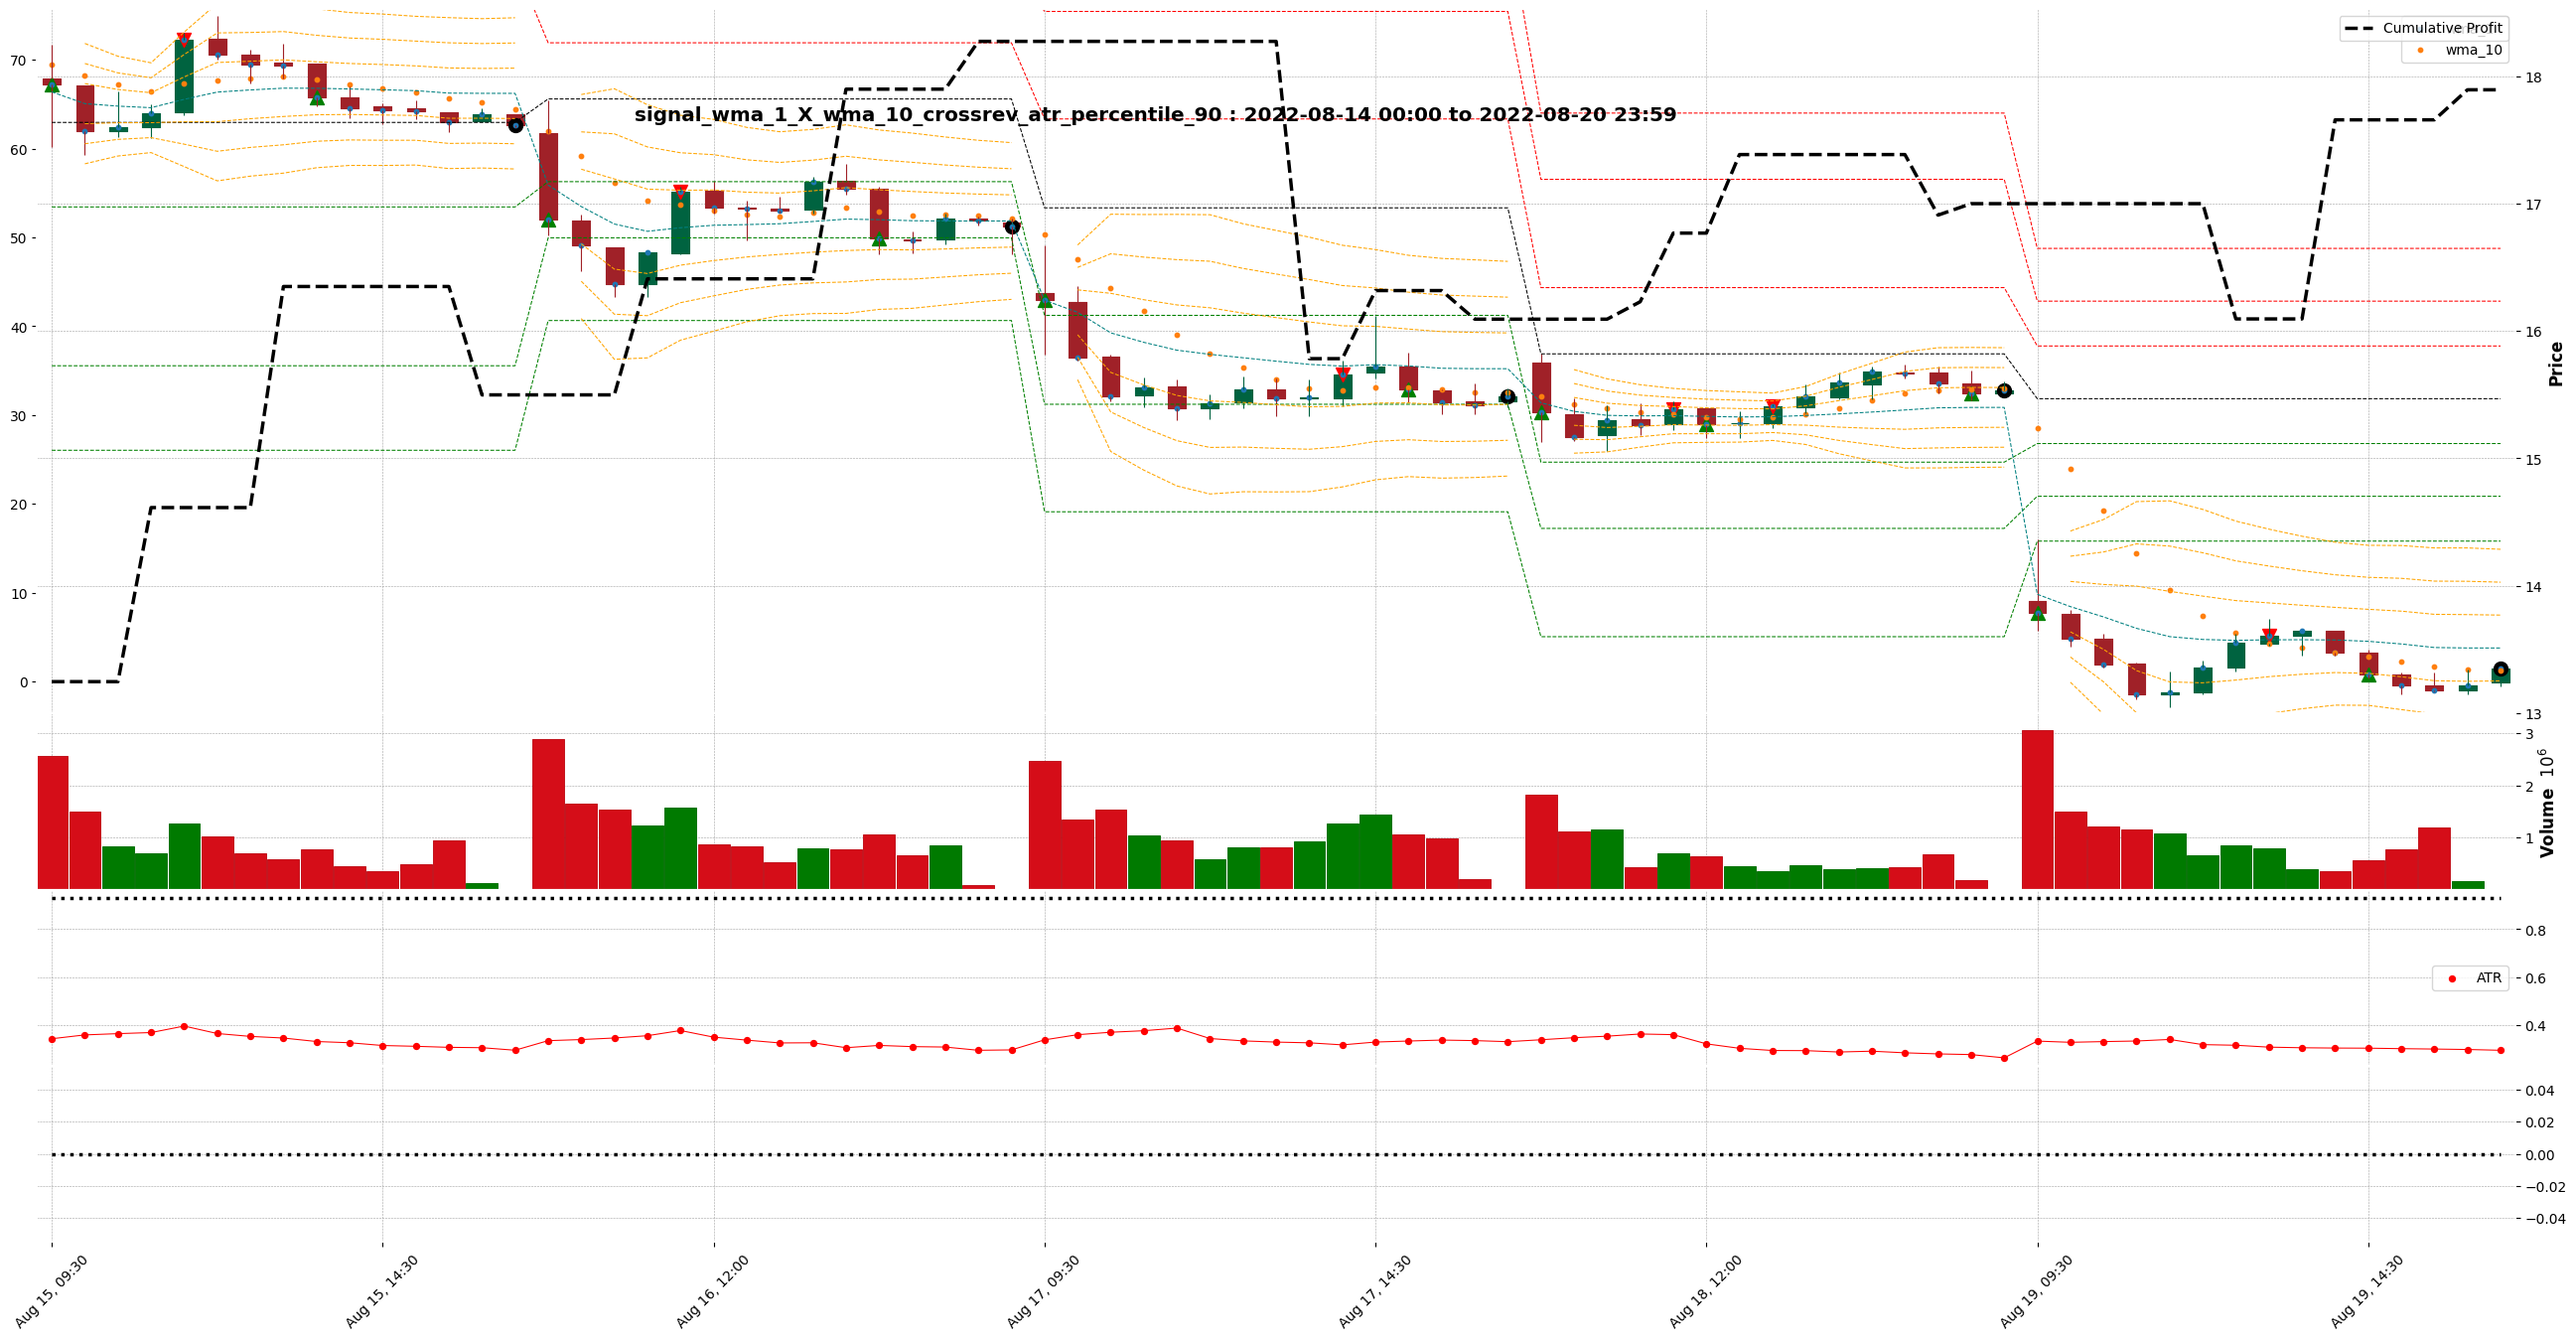

In [109]:
# # Check for secondary y-axis if you get multiple y-axes
# plot_for_time_range(df_viz, 
#                     '2021-01-21', 
#                     '2021-01-27', 
#                     start_time='00:00', 
#                     end_time='23:59', 
#                     include_pivot_points=True, 
#                     include_vwap=True, 
#                     signal_column='signal_wma_2_X_wma_20_crossrev_atr_percentile_1',
#                     include_indicator=True)

# Get the minimum and maximum dates in the dataset
min_date = df_viz.index.min().date()
max_date = df_viz.index.max().date()

# Calculate the maximum allowable start date to ensure one week fits within the dataset
max_start_date = max_date - pd.Timedelta(days=6)

# Randomly choose a start date within the valid range
random_start_date = min_date + pd.to_timedelta(np.random.randint(0, (max_start_date - min_date).days + 1), unit='D')

# Define the end date exactly one week after the start date
random_end_date = random_start_date + pd.Timedelta(days=6)

# Convert the dates to strings if necessary
random_start_date_str = random_start_date.strftime('%Y-%m-%d')
random_end_date_str = random_end_date.strftime('%Y-%m-%d')

# Now, use these randomly selected dates in your plotting function
plot_for_time_range(df_viz, 
                    random_start_date_str, 
                    random_end_date_str, 
                    start_time='00:00', 
                    end_time='23:59', 
                    include_pivot_points=True, 
                    include_vwap=True, 
                    signal_column='signal_wma_1_X_wma_10_crossrev_atr_percentile_90',
                    include_indicator=True)

In [110]:
pd.options.display.float_format = '{:,.4f}'.format # Change formatting of float output
pd.set_option('display.max_columns', None) # Displays all columns
pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
# pd.reset_option('display.max_rows') # Display default abbreviated rows

In [111]:
# A mean reversion trading strategy is based on the concept that asset prices tend to revert to their historical mean or average level over time. This type of strategy typically involves identifying when a security has deviated significantly from its average value and taking a position with the expectation that it will revert to the mean. Here are some ideas and indicators that can be used to create a mean reversion algorithmic trading strategy:

# ### 1. **Bollinger Bands**
# - **Description:** Bollinger Bands consist of a middle band (typically a 20-period simple moving average), an upper band, and a lower band (both set a certain number of standard deviations away from the middle band).
# - **Strategy:** Buy when the price touches the lower Bollinger Band and sell when it touches the upper Bollinger Band.

# ### 2. **Relative Strength Index (RSI)**
# - **Description:** RSI is a momentum oscillator that measures the speed and change of price movements on a scale of 0 to 100.
# - **Strategy:** Buy when the RSI crosses below a certain threshold (e.g., 30) indicating an oversold condition and sell when it crosses above a threshold (e.g., 70) indicating an overbought condition.

# ### 3. **Moving Average Convergence Divergence (MACD)**
# - **Description:** MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.
# - **Strategy:** Look for divergence from the price trend to identify potential mean reversion opportunities.

# ### 4. **Z-Score of Price**
# - **Description:** The Z-Score measures the number of standard deviations a data point (current price) is from the mean.
# - **Strategy:** Calculate the Z-Score of the price. Buy when the Z-Score is below -2 (indicating the price is significantly lower than the mean) and sell when it is above +2.

# ### 5. **Keltner Channels**
# - **Description:** Keltner Channels are volatility-based envelopes set above and below an exponential moving average.
# - **Strategy:** Buy when the price touches the lower Keltner Channel and sell when it touches the upper Keltner Channel.

# ### 6. **Statistical Arbitrage (Pairs Trading)**
# - **Description:** Pairs trading involves taking a long position in one security and a short position in another related security, based on the historical correlation between the two.
# - **Strategy:** Identify pairs of securities with a high correlation, then buy the underperforming security and sell the outperforming security when their price spread deviates significantly from the mean.

# ### 7. **Commodity Channel Index (CCI)**
# - **Description:** CCI measures the current price level relative to an average price level over a given period.
# - **Strategy:** Buy when the CCI falls below -100 (indicating an oversold condition) and sell when it rises above +100 (indicating an overbought condition).

# ### 8. **Stochastic Oscillator**
# - **Description:** The stochastic oscillator compares a particular closing price of a security to a range of its prices over a certain period.
# - **Strategy:** Buy when the stochastic oscillator falls below 20 (indicating oversold conditions) and sell when it rises above 80 (indicating overbought conditions).

# ### 9. **Mean Reversion Channels**
# - **Description:** Create a mean reversion channel based on historical price data (e.g., using rolling mean and standard deviation).
# - **Strategy:** Buy when the price falls below the lower channel and sell when it rises above the upper channel.

# ### 10. **Exponential Moving Average (EMA)**
# - **Description:** EMA places a greater weight and significance on the most recent data points.
# - **Strategy:** Use the difference between short-term and long-term EMAs to identify mean reversion opportunities.

# ### Implementing a Mean Reversion Strategy
# To implement a mean reversion trading strategy, follow these steps:

# 1. **Select the Indicator(s):** Choose one or a combination of the above indicators based on your research and backtesting results.
# 2. **Set Parameters:** Define the parameters for your chosen indicators (e.g., periods for moving averages, thresholds for RSI, etc.).
# 3. **Develop Entry and Exit Rules:** Create clear rules for entering and exiting trades based on the indicator signals.
# 4. **Backtest the Strategy:** Test your strategy on historical data to evaluate its performance and make adjustments as necessary.
# 5. **Implement Risk Management:** Define risk management rules, including position sizing, stop-loss levels, and take-profit levels.
# 6. **Monitor and Adjust:** Continuously monitor the performance of your strategy and make adjustments based on changing market conditions.

# By combining these indicators and strategies, you can develop a robust mean reversion algorithmic trading strategy tailored to your specific market and asset class.

To identify when it's a good time to switch to a trend-following strategy, you're looking for an indicator that can signal the beginning of a strong and sustained trend. Here are a few indicators and methods that can help you predict when the market is likely to exhibit consistent movement in one direction:

### 1. **Average Directional Index (ADX)**
   - **What it is**: The ADX measures the strength of a trend without considering its direction. It ranges from 0 to 100, with higher values indicating a stronger trend.
   - **How to use it**: A common threshold is 25; when the ADX crosses above 25, it suggests a strong trend is forming. Pair it with the +DI and -DI lines to determine the direction of the trend.

### 2. **Moving Average Convergence Divergence (MACD)**
   - **What it is**: MACD is a momentum indicator that shows the relationship between two moving averages of prices. It consists of the MACD line, the signal line, and the histogram.
   - **How to use it**: When the MACD line crosses above the signal line from below, it can indicate the start of an upward trend, and vice versa for downward trends. Consistent divergence between the MACD line and the signal line can signal a strong trend.

### 3. **Bollinger Bands Squeeze**
   - **What it is**: Bollinger Bands are a volatility indicator that consists of a moving average and two standard deviations above and below it.
   - **How to use it**: When the bands contract, it indicates lower volatility, which often precedes a significant price move. A subsequent expansion of the bands, along with price movement outside of the bands, can signal the start of a trend.

### 4. **Keltner Channels**
   - **What it is**: Similar to Bollinger Bands but based on the Average True Range (ATR), Keltner Channels also provide a volatility-based envelope.
   - **How to use it**: When the price consistently moves outside of the Keltner Channel, it indicates the presence of a strong trend. If the price remains above the upper band or below the lower band, it may signal the beginning of a sustained trend.

### 5. **Ichimoku Cloud**
   - **What it is**: The Ichimoku Cloud is a comprehensive indicator that provides information on trend direction, momentum, and support/resistance levels.
   - **How to use it**: A strong trend is indicated when the price is above the cloud (for an uptrend) or below the cloud (for a downtrend). The crossing of the Tenkan-sen and Kijun-sen lines can also signal trend changes.

### 6. **Trend Strength Indicator (TSI)**
   - **What it is**: TSI is an oscillator that measures the strength of the current trend. It is similar to the Relative Strength Index (RSI) but is designed to be more sensitive to market trends.
   - **How to use it**: Positive TSI values suggest bullish trends, while negative values indicate bearish trends. Consistent values above or below a certain threshold can suggest a strong trend.

### 7. **Donchian Channels**
   - **What it is**: Donchian Channels are formed by the highest high and the lowest low of a specific period.
   - **How to use it**: A breakout above the upper band can signal the start of an upward trend, while a breakout below the lower band can indicate a downward trend. This method is particularly useful for identifying the start of strong, directional movements.

### 8. **Heikin-Ashi Candles**
   - **What it is**: Heikin-Ashi is a type of candlestick chart that smooths out price data to make trends easier to identify.
   - **How to use it**: Long consecutive Heikin-Ashi candles in one direction with little to no wicks indicate a strong trend. A switch from small or indecisive candles to long, consistent candles can signal the beginning of a strong trend.

### Combining Indicators for Better Accuracy
Often, combining multiple indicators can provide a more reliable signal for switching to a trend-following strategy. For example:
- Use ADX to confirm the strength of a trend.
- Combine Bollinger Bands Squeeze with MACD to identify when a breakout is likely to result in a sustained trend.

By using these indicators, you can increase your chances of identifying the optimal time to switch to a trend-following strategy, capitalizing on consistent movement in one direction.